### DSP - Feature Engineering

- Is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 
    - creating new features from existing data (encoding, binning, interactions, clusters, etc.)
    - scaling and/or transforming features 
    
- The goal of feature engineering is to improve the predictive power of machine learning models by making the data more relevant and useful to the model. 
    - It is a crucial step in the process of building a machine learning model, as the quality of the features used to train the model has a significant impact on its performance.

In [1]:
# libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from feature_engine.encoding import RareLabelEncoder # ! pip install feature-engine
from sklearn.model_selection import train_test_split
from optbinning import OptimalBinning
import random
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from scipy.stats.stats import pearsonr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from instrumentum.model_tuning.wrapper_optuna import OptunaSearchCV
from instrumentum.model_tuning._optuna_dispatchers import optuna_param_disp
from lightgbm import LGBMClassifier
from instrumentum.feature_selection.correlation import ClusterSelection
from instrumentum.feature_selection.stepwise import DynamicStepwise
import scipy.stats as ss
import math
from collections import Counter
from sklearn.inspection import permutation_importance

#pandas option to show all columns 
pd.set_option('display.max.columns', None)

#global figure size for matplotlib
plt.rcParams['figure.figsize'] = (18, 6)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/var/folders/qf/w2n_959j22x1qz6775lxlqsm0000gn/T/ipykernel_40681/2615287098.py:10: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Get data

In [2]:
# get data
df = pd.read_csv('dataset.csv')
print('(Rows, Columns): ',df.shape)
df.head(5)

(Rows, Columns):  (1000, 11)


,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer Balance,Loan Sanctioned Status,Loan Amount,Annual income,Customer Category,Target
0,6,A43,1169,67.0,A173,22876,Yes,192584,63890,B,1
1,48,A43,5951,22.0,A173,26204,Yes,275998,119895,C,2
2,12,A46,2096,49.0,A172,33814,No,0,13157,C,1
3,42,A42,7882,45.0,A173,20934,Yes,395792,130148,B,1
4,24,A40,4870,NaN,NaN,11109,Yes,156719,97403,C,2


### `Practice:`

Create a function that replaces the space between words in the columns with a single underscore.

In [3]:
# write code here
def standard_col_names(df:pd.DataFrame):
    col_names=[]
    for column in df.columns:
        col_names.append(' '.join(column.split()))
    df.columns = col_names
    df.columns = df.columns.str.replace(' ', '_')
    return df

In [4]:
df = standard_col_names(df)
df

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category,Target
0,6,A43,1169,67.0,A173,22876,Yes,192584,63890,B,1
1,48,A43,5951,22.0,A173,26204,Yes,275998,119895,C,2
2,12,A46,2096,49.0,A172,33814,No,0,13157,C,1
3,42,A42,7882,45.0,A173,20934,Yes,395792,130148,B,1
4,24,A40,4870,NaN,NaN,11109,Yes,156719,97403,C,2
...,...,...,...,...,...,...,...,...,...,...,...
995,12,A42,1736,31.0,A172,21581,No,0,11395,C,1
996,30,A41,3857,40.0,A174,7679,Yes,367837,85901,C,1
997,12,A43,804,38.0,A173,26301,No,0,12305,D,1
998,45,A43,1845,23.0,NaN,9010,Yes,241618,106876,C,2


### Train/Test split

In [5]:
# features, response
x , y = df.iloc[:,df.columns!='Target'].copy(), df['Target'].copy().map({2:1,1:0})

# train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=33)

# see data columns for first 5 rows
display(x_train.head(5))
y_train.head(5)

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,60,A49,7297,36.0,A173,1413,No,0,23824,D
935,30,A43,1919,30.0,A174,23817,No,0,18869,D
449,15,A45,1512,61.0,A173,20221,No,0,19006,D
495,24,A42,2996,20.0,A173,26907,No,0,12190,D
177,6,A43,338,52.0,A173,11680,Yes,309394,95414,B


973    1
935    1
449    1
495    1
177    0
Name: Target, dtype: int64

### Get Started: Statistical summary

In [6]:
x_train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Duration_in_months,670,NaN,NaN,NaN,20.9433,12.1458,4,12,18,24,60
Purpose,670,10,A43,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit_amount,670,NaN,NaN,NaN,3325.69,2883.8,250,1376,2359.5,4096.75,18424
Age_in_years,665,NaN,NaN,NaN,35.3323,11.1165,19,27,33,42,75
Job,667,4,A173,417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_Balance,670,NaN,NaN,NaN,25550.2,14200.7,1043,13374.8,25616.5,37318.8,49912
Loan_Sanctioned_Status,670,2,Yes,346,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loan_Amount,670,NaN,NaN,NaN,118499,136876,0,0,58623,233773,398918
Annual_income,670,NaN,NaN,NaN,61823.4,46951.9,10013,17300.2,64115,102370,149790
Customer_Category,670,4,C,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Imputing missing values

In [7]:
def numerical_imputator(X_train:pd.DataFrame,X_test:pd.DataFrame,col:str):
    X_train , X_test = X_train.copy() , X_test.copy()
    X_train[col] = X_train[col].fillna(X_train[col].median())
    X_test[col] = X_test[col].fillna(X_test[col].median())
    return X_train , X_test

def categorical_imputator(X_train:pd.DataFrame,X_test:pd.DataFrame,col:str):
    X_train , X_test = X_train.copy() , X_test.copy()
    X_train, X_test = X_train.replace('', np.nan), X_test.replace('', np.nan)
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')
    return X_train , X_test

x_train, x_test = numerical_imputator(X_train = x_train , X_test = x_test , col = 'Age_in_years')
x_train, x_test = categorical_imputator(X_train = x_train , X_test = x_test , col = 'Job') 

x_train.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Duration_in_months,670,NaN,NaN,NaN,20.9433,12.1458,4,12,18,24,60
Purpose,670,10,A43,183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit_amount,670,NaN,NaN,NaN,3325.69,2883.8,250,1376,2359.5,4096.75,18424
Age_in_years,670,NaN,NaN,NaN,35.3149,11.0768,19,27,33,41.75,75
Job,670,5,A173,417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_Balance,670,NaN,NaN,NaN,25550.2,14200.7,1043,13374.8,25616.5,37318.8,49912
Loan_Sanctioned_Status,670,2,Yes,346,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Loan_Amount,670,NaN,NaN,NaN,118499,136876,0,0,58623,233773,398918
Annual_income,670,NaN,NaN,NaN,61823.4,46951.9,10013,17300.2,64115,102370,149790
Customer_Category,670,4,C,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### `Practice`: Create a UDF that generated histogram for all numerical variables. 

The Function must take as input the dataframe to plot.

To create function:
1) create a list called `numerical_vars` that contains all the names of the numerical columns. 
    - `Hint:` Use .select_dtypes(exclude = object) on the dataframe a see what happens.
<br>
2) iterate over `numerical_vars` to plot a histogram for each numerical variables. Use bins = 20 for all visuals.
    - `Hint:` Use plt.show(); at the end of the loop
    - title: Histogram
    - y label: Occurence
    - x label: Variable name
<br>

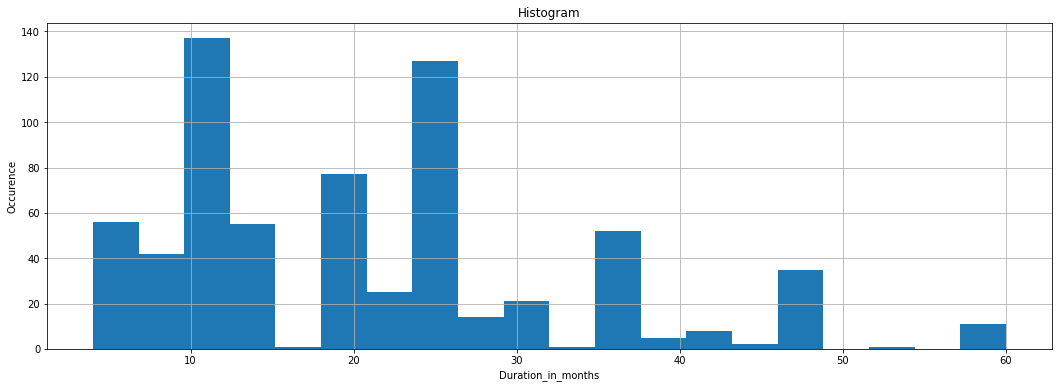

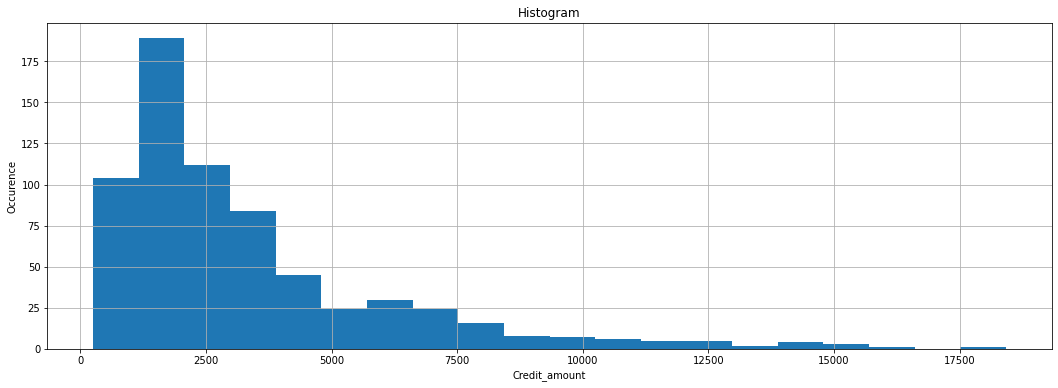

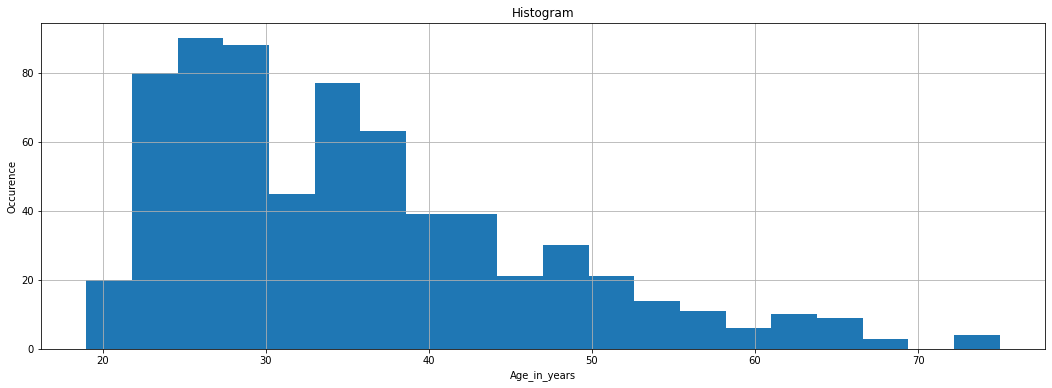

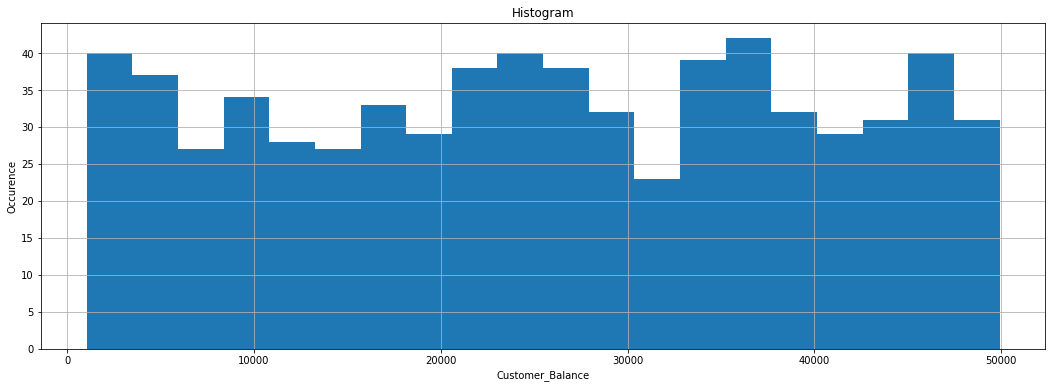

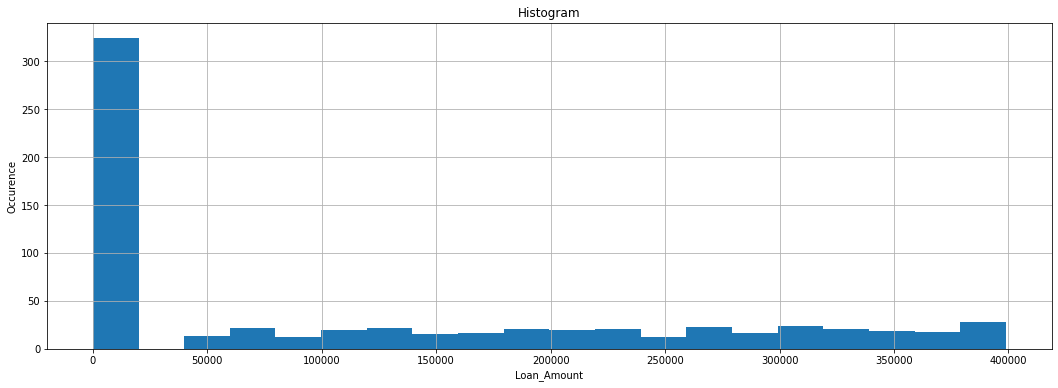

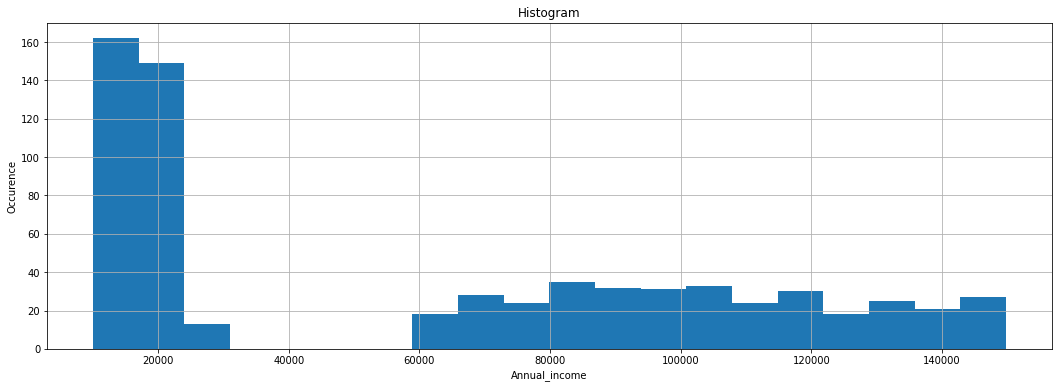

In [8]:
# write code here
def histogram_visual(X:pd.DataFrame):
    X = X.copy()
    numerical_vars = list(X.select_dtypes(exclude = object).columns)
    for i in numerical_vars:
        fig = X[i].hist(bins = 20)
        fig.set_ylabel('Occurence')
        fig.set_xlabel(i)
        fig.set_title('Histogram')
        plt.show();
        
histogram_visual(x_train)

### Numerical Features: 

- There are `Continuos` (values with decimals) and `Discrete` (integers) variables. 

- What is the distribution of my variables?
    - the distribution of a variable is a description of the relative numbers of times each possible outcome will occur in a number of trials.
    - linear and logistic models assume normality distribution for the prediction errors.
    - log trasnformations take the value distributions closer to normal.

- Next, we need to consider the sclale. 
    - is there a big jump from the smallest number to the largest?
    - methods that relies on distances are sensitive to scale, normalizing the data would help
    - tree based models are not sensitive to scale

- We need to make sure the if magnitudes matter. 
    - do we need to know magnitud at a specific granularity?
    - agreggation function can help to engineer feature to answer these questions.

- Can complex features be derived from existing features?
    - `Binning` can group values into bins
    - `Feature interaction` can capture interaction between 2 or more variables

### Binning function:

- Binning is a technique used to preprocess numerical data by dividing it into a set of bins, or intervals.

In [9]:
def binning(X_train:pd.DataFrame,X_test:pd.DataFrame,y_train:pd.Series,cols_to_bins:list):
    X_train , X_test = X_train.copy() , X_test.copy()
    for col in cols_to_bins:
        optb = OptimalBinning(name = col, dtype = "numerical", solver = "cp")
        optb.fit(X_train[col], y_train)
        optb.binning_table.build()
        gg= optb.binning_table.build()
        bins = list(gg['Bin'].values)
        bins.remove(''), bins.remove('Special'), bins.remove('Missing')
        limits = []
        for i in bins:
            try:
                limits.append(float(i.split(',')[0].replace('(','').replace('[','')))
                limits.append(float(i.split(',')[1].replace(')','').replace(']','')))
            except:
                pass
        limits = list(set(limits))
        limits.sort()
        X_train[col] = pd.cut(X_train[col], bins=limits, labels=bins,precision=0,duplicates='drop').astype(object)
        X_test[col] = pd.cut(X_test[col], bins=limits, labels=bins,precision=0,duplicates='drop').astype(object)
    return X_train , X_test

In [10]:
cols_to_bins = ['Duration_in_months', 'Credit_amount', 'Age_in_years', 'Loan_Amount', 'Annual_income', 'Customer_Balance']
x_train_bin, x_test_bin = binning(X_train = x_train, X_test = x_test, y_train = y_train,cols_to_bins = cols_to_bins)
x_train_bin

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,"[43.50, inf)",A49,"[6686.00, 8918.00)","[34.50, 36.50)",A173,"(-inf, 32009.00)",No,"(-inf, 137505.00)","[21003.50, 71186.50)",D
935,"[15.50, 34.50)",A43,"[1373.00, 2675.00)","[25.50, 34.50)",A174,"(-inf, 32009.00)",No,"(-inf, 137505.00)","[12274.00, 21003.50)",D
449,"[11.50, 15.50)",A45,"[1373.00, 2675.00)","[52.50, inf)",A173,"(-inf, 32009.00)",No,"(-inf, 137505.00)","[12274.00, 21003.50)",D
495,"[15.50, 34.50)",A42,"[2675.00, 3504.00)","(-inf, 25.50)",A173,"(-inf, 32009.00)",No,"(-inf, 137505.00)","(-inf, 12274.00)",D
177,"(-inf, 7.50)",A43,"(-inf, 959.50)","[38.50, 52.50)",A173,"(-inf, 32009.00)",Yes,"[301605.50, inf)","[85457.00, 107094.00)",B
...,...,...,...,...,...,...,...,...,...,...
658,"[15.50, 34.50)",A49,"[4049.50, 6686.00)","[25.50, 34.50)",A173,"(-inf, 32009.00)",Yes,"(-inf, 137505.00)","[71186.50, 85457.00)",C
578,"[34.50, 43.50)",A40,"[2675.00, 3504.00)","[25.50, 34.50)",A173,"(-inf, 32009.00)",No,"(-inf, 137505.00)","[12274.00, 21003.50)",C
728,"[43.50, inf)",A49,"[4049.50, 6686.00)","[52.50, inf)",A173,"(-inf, 32009.00)",No,"(-inf, 137505.00)","(-inf, 12274.00)",D
391,"[11.50, 15.50)",A42,"[959.50, 1373.00)","(-inf, 25.50)",A172,"(-inf, 32009.00)",Yes,"[213999.50, 301605.50)","[85457.00, 107094.00)",B


### Another route: keep columns numericals, but transform , check for outliers and scale/normalize

- If choosing to work with numerical columns, keep in mind that there are a lot of trasnformations, scaling and normalization methods and that sometimes you may need to iterate this step.

### Square Root Transformation

 $$ Y = \sqrt{X} $$

In [11]:
# sqrt trasnfromation
def sqrt_trasnform(X_train:pd.DataFrame,X_test:pd.DataFrame):
    X_train , X_test  = X_train.copy() , X_test.copy()
    numerical_vars = list(X_train.select_dtypes(exclude = object).columns)
    X_train[numerical_vars] = np.sqrt(X_train[numerical_vars])
    X_test[numerical_vars] = np.sqrt(X_test[numerical_vars])
    return X_train, X_test

x_train_sqrt, x_test_sqrt = sqrt_trasnform(X_train = x_train,X_test = x_test)
x_train_sqrt

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,7.745967,A49,85.422479,6.000000,A173,37.589892,No,0.000000,154.350251,D
935,5.477226,A43,43.806392,5.477226,A174,154.327574,No,0.000000,137.364479,D
449,3.872983,A45,38.884444,7.810250,A173,142.200563,No,0.000000,137.862250,D
495,4.898979,A42,54.735729,4.472136,A173,164.033533,No,0.000000,110.408333,D
177,2.449490,A43,18.384776,7.211103,A173,108.074049,Yes,556.231966,308.891567,B
...,...,...,...,...,...,...,...,...,...,...
658,5.477226,A49,64.969223,5.291503,A173,135.893341,Yes,292.138666,281.167210,C
578,6.000000,A40,53.103672,5.196152,A173,176.490793,No,0.000000,129.996154,C
728,6.928203,A49,80.099938,7.681146,A173,125.395375,No,0.000000,108.069422,D
391,3.464102,A42,31.352831,4.358899,A172,82.121861,Yes,539.130782,292.899300,B


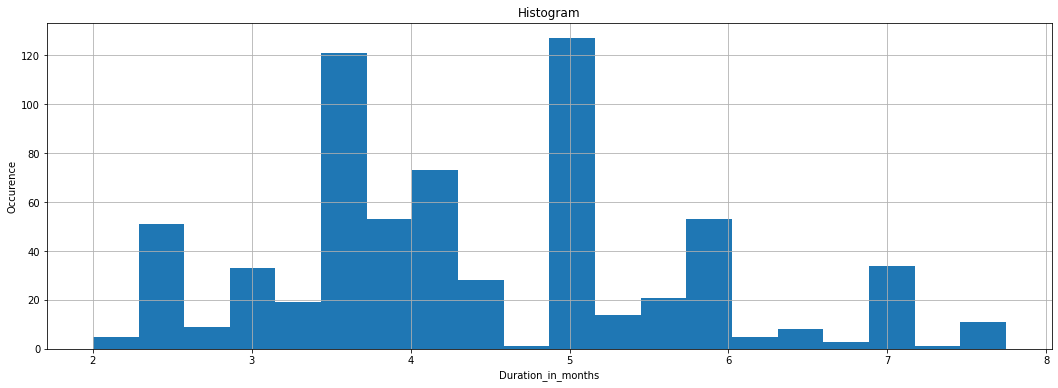

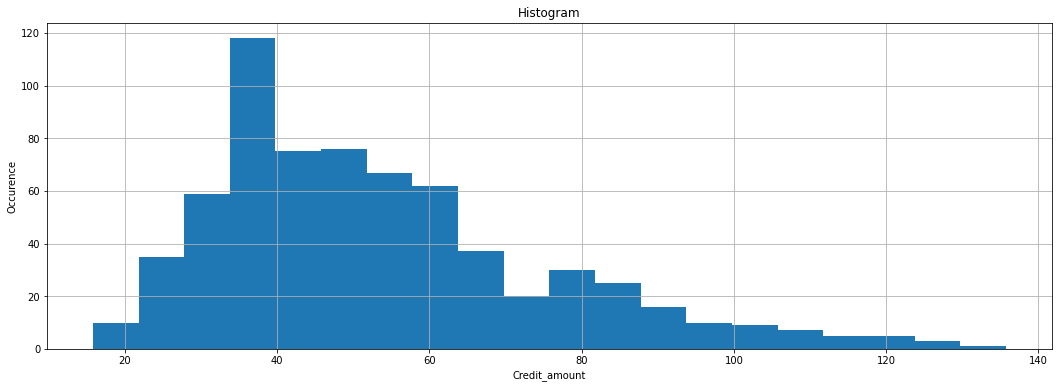

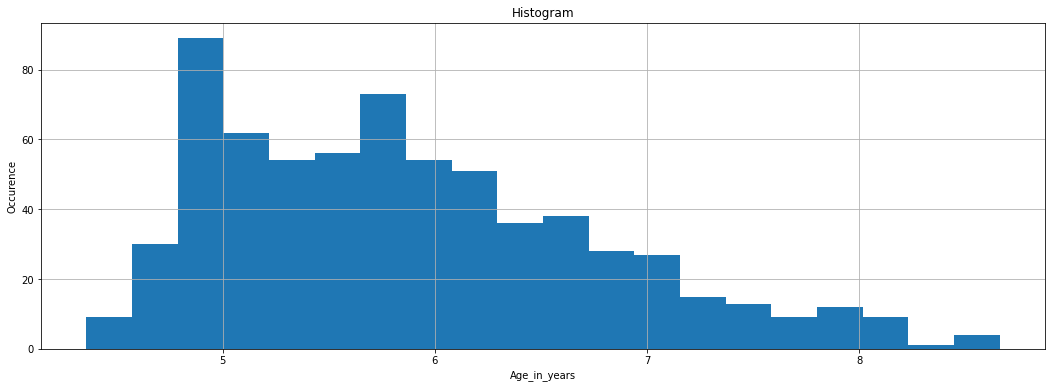

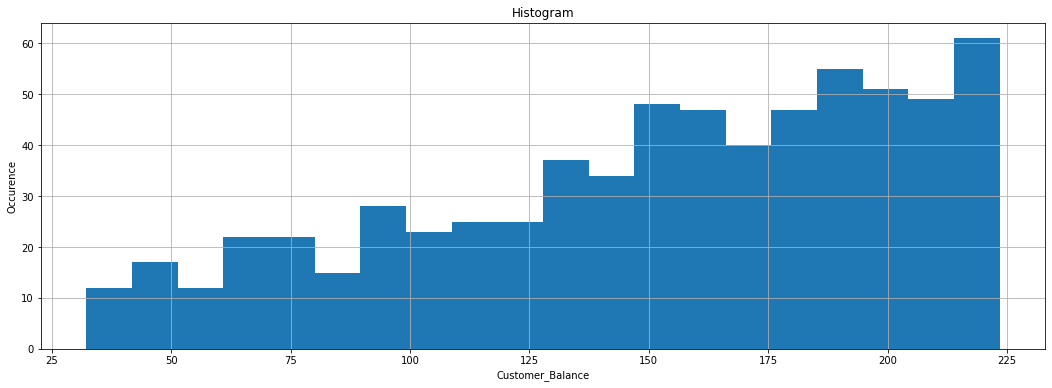

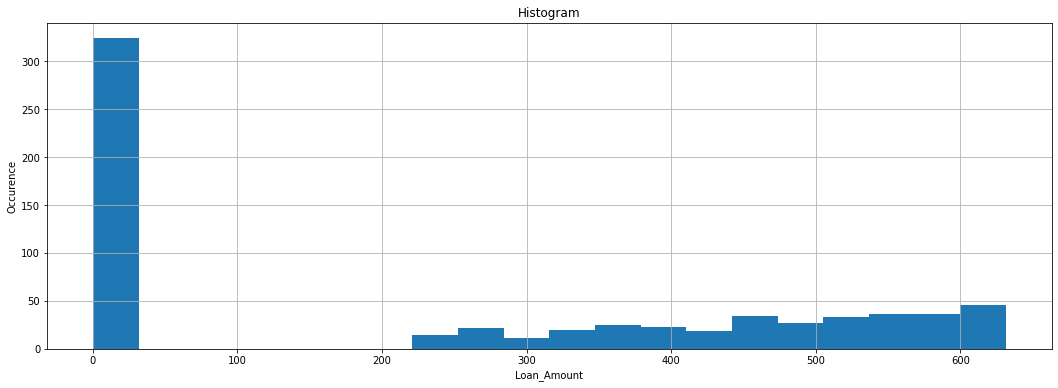

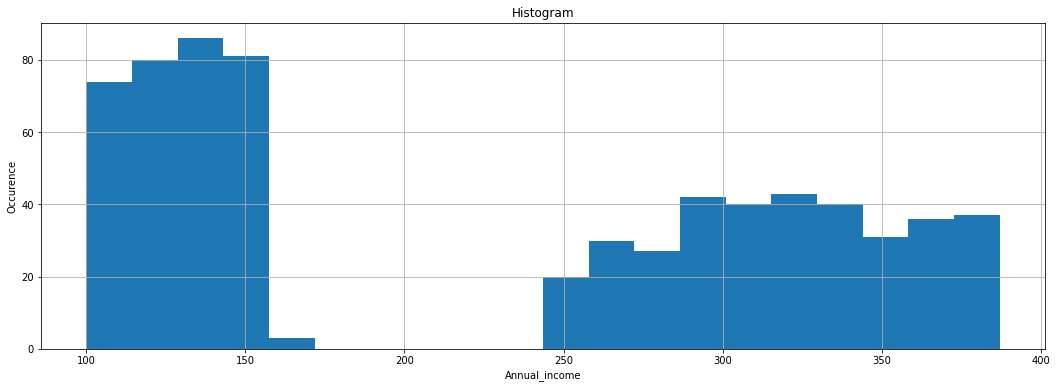

In [12]:
histogram_visual(x_train_sqrt)

### Cube Root Trasformation
 $$ Y = \sqrt[3]{X} $$

In [13]:
# cube root trasnfromation
def cbrt_trasnform(X_train:pd.DataFrame,X_test:pd.DataFrame):
    X_train , X_test  = X_train.copy() , X_test.copy()
    numerical_vars = list(X_train.select_dtypes(exclude = object).columns)
    X_train[numerical_vars] = np.cbrt(X_train[numerical_vars])
    X_test[numerical_vars] = np.cbrt(X_test[numerical_vars])
    return X_train, X_test

x_train_cbrt, x_test_cbrt = cbrt_trasnform(X_train = x_train,X_test = x_test)
x_train_cbrt

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,3.914868,A49,19.396116,3.301927,A173,11.221409,No,0.000000,28.774308,D
935,3.107233,A43,12.426772,3.107233,A174,28.771490,No,0.000000,26.622549,D
449,2.466212,A45,11.477587,3.936497,A173,27.243791,No,0.000000,26.686825,D
495,2.884499,A42,14.416083,2.714418,A173,29.965516,No,0.000000,23.014484,D
177,1.817121,A43,6.965820,3.732511,A173,22.688944,Yes,67.634865,45.695212,B
...,...,...,...,...,...,...,...,...,...,...
658,3.107233,A49,16.161132,3.036589,A173,26.432127,Yes,44.027703,42.918360,C
578,3.301927,A40,14.128076,3.000000,A173,31.464056,No,0.000000,25.661793,C
728,3.634241,A49,18.581814,3.892996,A173,25.052689,No,0.000000,22.688296,D
391,2.289428,A42,9.943009,2.668402,A172,18.893214,Yes,66.241387,44.104092,B


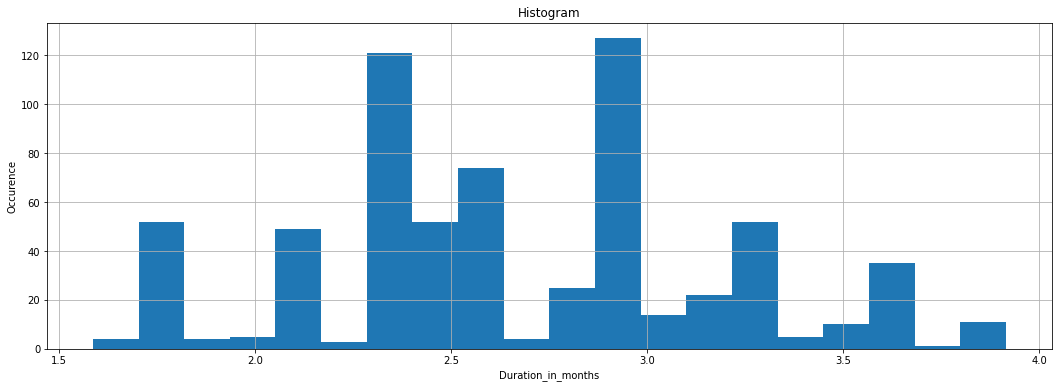

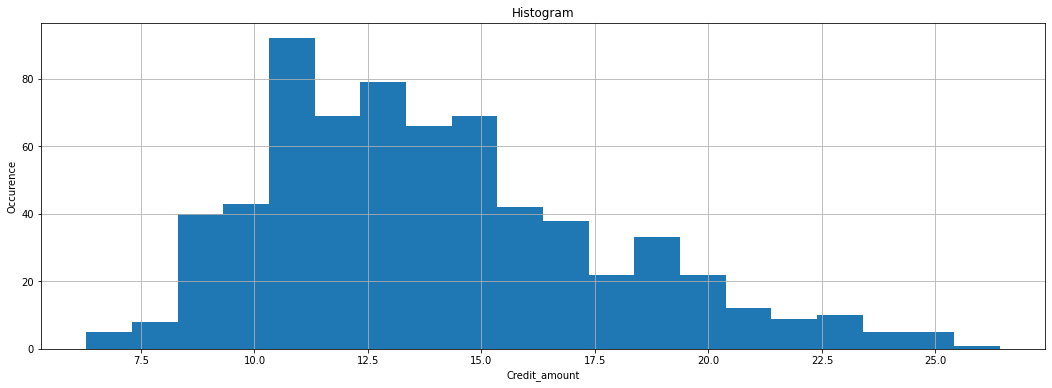

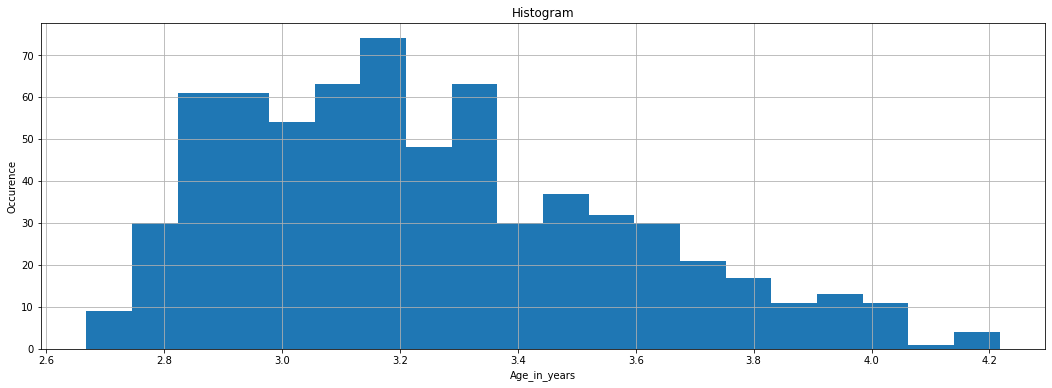

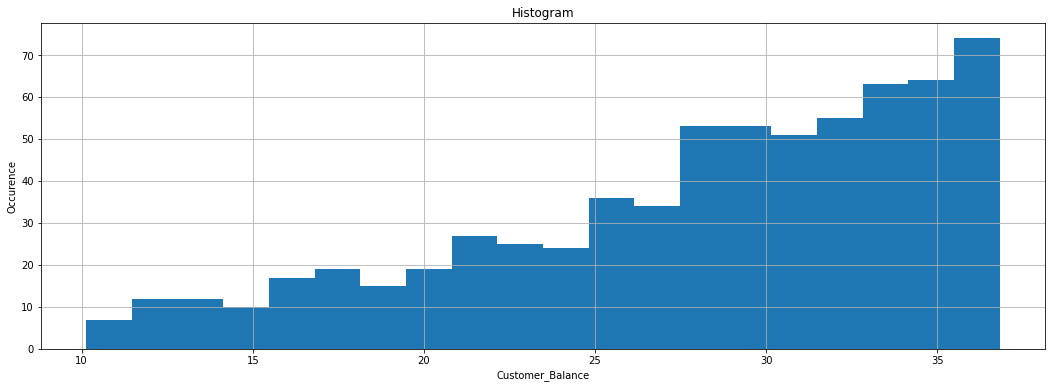

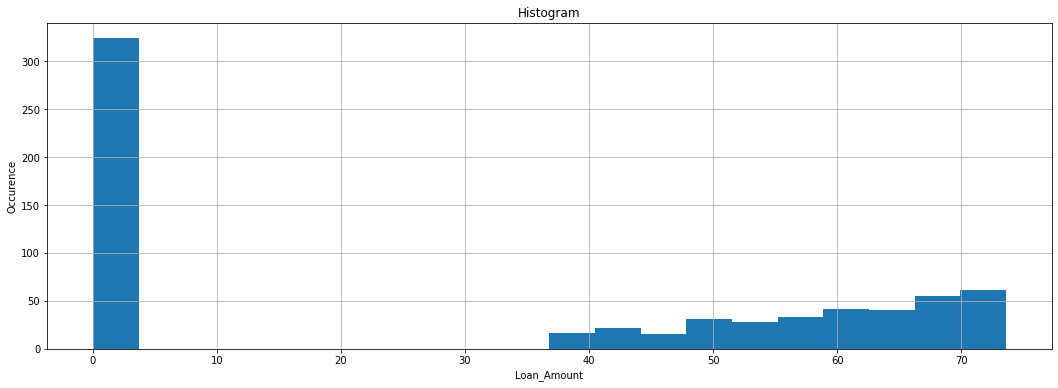

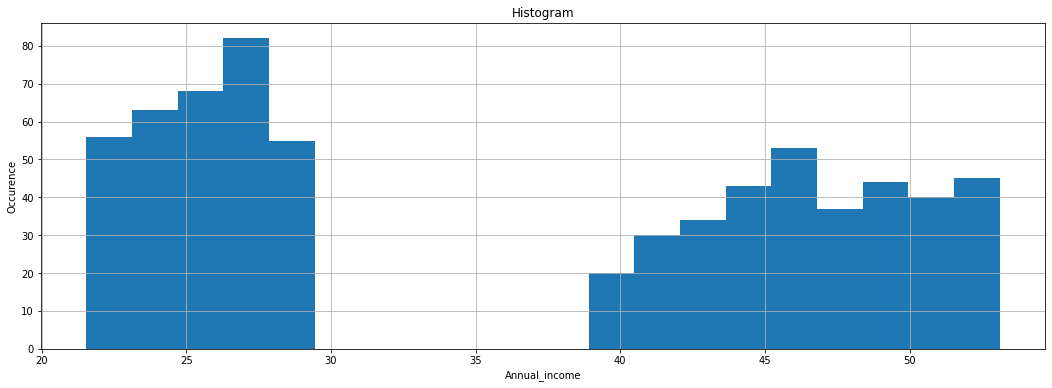

In [14]:
histogram_visual(x_train_cbrt)

### Log Transformation
 $$ Y = \log{X} $$

In [15]:
# log trasnfromation
def log_trasnform(X_train:pd.DataFrame,X_test:pd.DataFrame):
    X_train , X_test  = X_train.copy() , X_test.copy()
    numerical_vars = list(X_train.select_dtypes(exclude = object).columns)
    X_train[numerical_vars] = np.log10(X_train[numerical_vars]+1)
    X_test[numerical_vars] = np.log10(X_test[numerical_vars]+1)
    return X_train, X_test

x_train_log, x_test_log = log_trasnform(X_train = x_train,X_test = x_test)
x_train_log

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,1.785330,A49,3.863204,1.568202,A173,3.150449,No,0.000000,4.377033,D
935,1.491362,A43,3.283301,1.491362,A174,4.376905,No,0.000000,4.275772,D
449,1.204120,A45,3.179839,1.792392,A173,4.305824,No,0.000000,4.278914,D
495,1.397940,A42,3.476687,1.322219,A173,4.429881,No,0.000000,4.086039,D
177,0.845098,A43,2.530200,1.724276,A173,4.067480,Yes,5.490513,4.979617,B
...,...,...,...,...,...,...,...,...,...,...
658,1.491362,A49,3.625518,1.462398,A173,4.266420,Yes,4.931183,4.897935,C
578,1.568202,A40,3.450403,1.447158,A173,4.493458,No,0.000000,4.227887,C
728,1.690196,A49,3.807332,1.778151,A173,4.196591,No,0.000000,4.067443,D
391,1.113943,A42,2.992995,1.301030,A172,3.828982,Yes,5.463390,4.933442,B


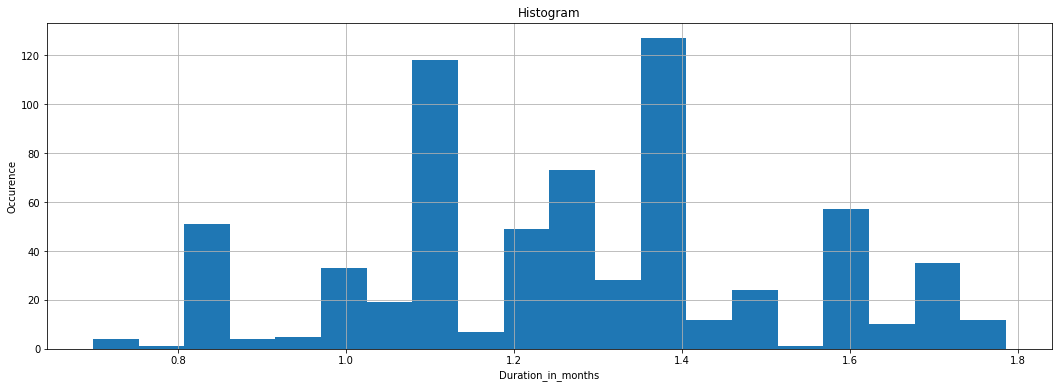

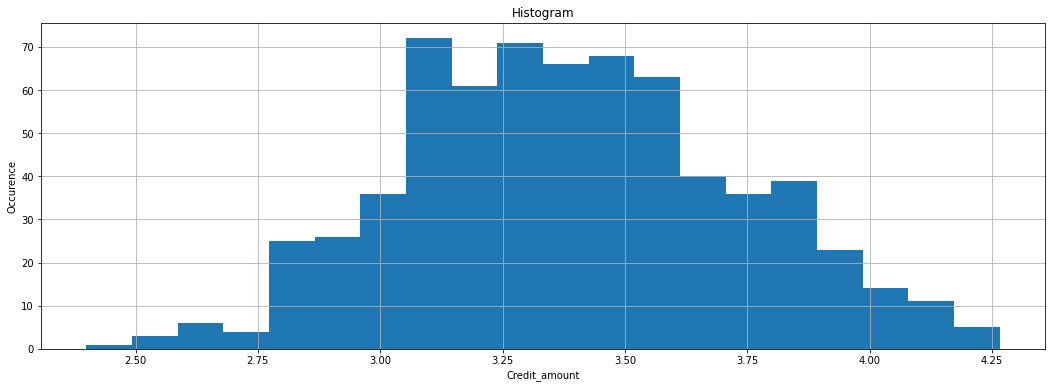

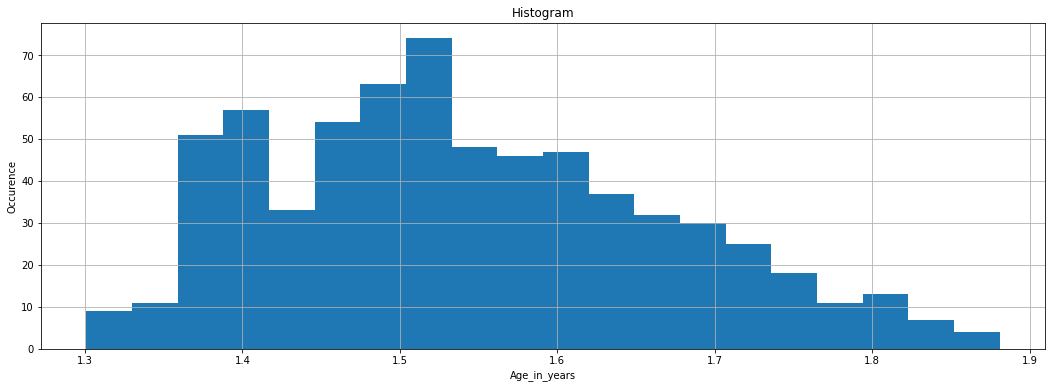

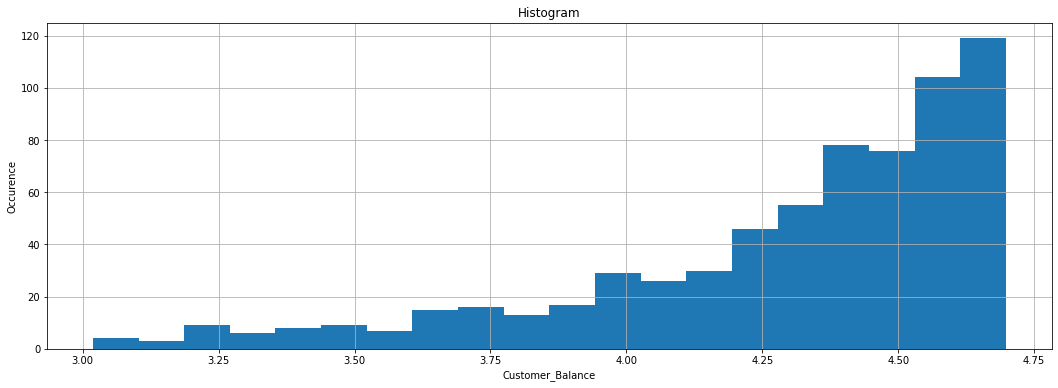

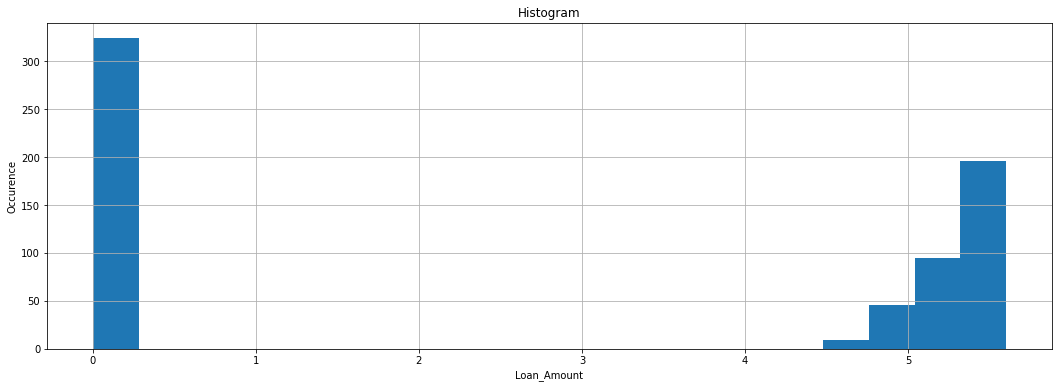

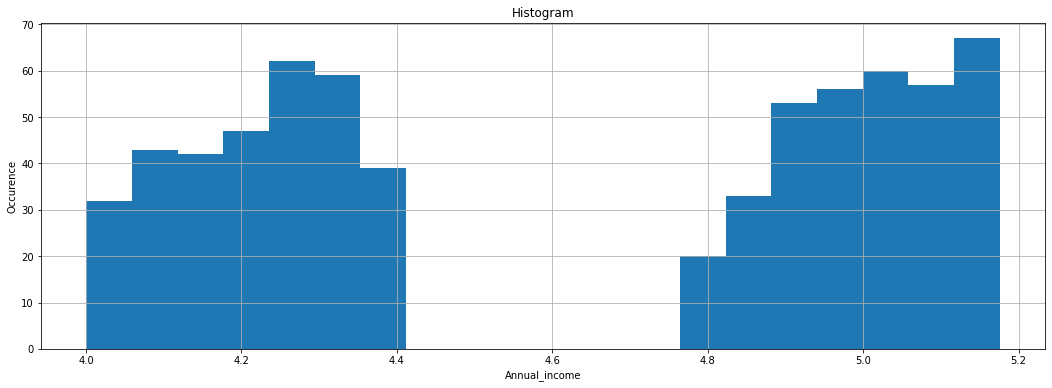

In [16]:
histogram_visual(x_train_log)

### Outliers:

- Outliers are data points that are significantly different from the rest of the data. 

- They can be caused by errors in data collection, measurement, or entry, or they can be genuine unusual observations.

In [17]:
def iqr_outliers(X:pd.DataFrame):
    X = X.copy()
    numerical_vars = list(X.select_dtypes(exclude = object).columns)
    for j in numerical_vars:
        Q1 = np.percentile(X[j], 25) 
        Q2 = np.percentile(X[j], 50) 
        Q3 = np.percentile(X[j], 75) 
        IQR = Q3 - Q1
        low_lim , up_lim = Q1 - 1.5 * IQR , Q3 + 1.5 * IQR
        temp = []
        for i in X.index:
            if X.loc[i,j] > up_lim:
                 temp.append(random.uniform(Q2, Q3))
            elif X.loc[i,j] < low_lim:
                temp.append(random.uniform(Q1, Q2))
            else:
                temp.append(X.loc[i,j])
        X[j] = temp
    return X
x_train_log, x_test_log = iqr_outliers(x_train_log) ,iqr_outliers(x_test_log)
x_train_log

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,1.785330,A49,3.863204,1.568202,A173,4.249862,No,0.000000,4.377033,D
935,1.491362,A43,3.283301,1.491362,A174,4.376905,No,0.000000,4.275772,D
449,1.204120,A45,3.179839,1.792392,A173,4.305824,No,0.000000,4.278914,D
495,1.397940,A42,3.476687,1.322219,A173,4.429881,No,0.000000,4.086039,D
177,0.845098,A43,2.530200,1.724276,A173,4.067480,Yes,5.490513,4.979617,B
...,...,...,...,...,...,...,...,...,...,...
658,1.491362,A49,3.625518,1.462398,A173,4.266420,Yes,4.931183,4.897935,C
578,1.568202,A40,3.450403,1.447158,A173,4.493458,No,0.000000,4.227887,C
728,1.690196,A49,3.807332,1.778151,A173,4.196591,No,0.000000,4.067443,D
391,1.113943,A42,2.992995,1.301030,A172,3.828982,Yes,5.463390,4.933442,B


### MinMax Scaler
- It rescales the dataset to the range of 0 and 1.

$$ X_{SCALED} = \frac{(X - X_{MIN})}{(X_{MAX} - X_{MIN})} $$

In [18]:
def min_max_scale(X_train:pd.DataFrame,X_test:pd.DataFrame):
    X_train , X_test = X_train.copy() , X_test.copy()
    numerical_vars = list(X_train.select_dtypes(exclude = object).columns)
    X_train[numerical_vars] = MinMaxScaler().fit_transform(X_train[numerical_vars])
    X_test[numerical_vars] = MinMaxScaler().fit_transform(X_test[numerical_vars])
    return X_train , X_test

x_train_log_minmax, x_test_log_minmax = min_max_scale(X_train = x_train_log, X_test = x_test_log)
x_train_log_minmax

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,1.000000,A49,0.768210,0.460813,A173,0.637158,No,0.000000,0.320395,D
935,0.729401,A43,0.434012,0.328281,A174,0.739971,No,0.000000,0.234207,D
449,0.464993,A45,0.374387,0.847492,A173,0.682447,No,0.000000,0.236881,D
495,0.643406,A42,0.545460,0.036547,A173,0.782844,No,0.000000,0.072715,D
177,0.134512,A43,0.000000,0.730007,A173,0.489560,Yes,0.980294,0.833286,B
...,...,...,...,...,...,...,...,...,...,...
658,0.729401,A49,0.631232,0.278325,A173,0.650558,Yes,0.880429,0.763762,C
578,0.800132,A40,0.530313,0.252039,A173,0.834295,No,0.000000,0.193449,C
728,0.912429,A49,0.736011,0.822930,A173,0.594046,No,0.000000,0.056887,D
391,0.381985,A42,0.266709,0.000000,A172,0.296548,Yes,0.975451,0.793984,B


### Standard Scaler
- Standardizes the column so it has mean = 0 and standard deviation = 1.

$$ X_{SCALED} = \frac{(X - X_{MEAN})}{(X_{STD})} $$

In [19]:
def standard_scale(X_train:pd.DataFrame,X_test:pd.DataFrame):
    X_train , X_test = X_train.copy() , X_test.copy()
    numerical_vars = list(X_train.select_dtypes(exclude = object).columns)
    X_train[numerical_vars] = StandardScaler().fit_transform(X_train[numerical_vars])
    X_test[numerical_vars] = StandardScaler().fit_transform(X_test[numerical_vars])
    return X_train , X_test

x_train_log_std, x_test_log_std = standard_scale(X_train = x_train_log, X_test = x_test_log)
x_train_log_std

,Duration_in_months,Purpose,Credit_amount,Age_in_years,Job,Customer_Balance,Loan_Sanctioned_Status,Loan_Amount,Annual_income,Customer_Category
973,2.134272,A49,1.404547,0.213462,A173,-0.321892,No,-1.031183,-0.607878,D
935,0.898544,A43,-0.315960,-0.406597,A174,0.115220,No,-1.031183,-0.857126,D
449,-0.308908,A45,-0.622922,2.022558,A173,-0.129346,No,-1.031183,-0.849393,D
495,0.505836,A42,0.257793,-1.771488,A173,0.297493,No,-1.031183,-1.324141,D
177,-1.818096,A43,-2.550330,1.472899,A173,-0.949407,Yes,1.036172,0.875347,B
...,...,...,...,...,...,...,...,...,...,...
658,0.898544,A49,0.699360,-0.640319,A173,-0.264923,Yes,0.825566,0.674292,C
578,1.221550,A40,0.179813,-0.763298,A173,0.516238,No,-1.031183,-0.974992,C
728,1.734367,A49,1.238782,1.907645,A173,-0.505181,No,-1.031183,-1.369915,D
391,-0.687975,A42,-1.177267,-1.942475,A172,-1.769998,Yes,1.025959,0.761690,B


### Categorical Features: 

- In some categorical variables, the labels (levels) have a intrisic order, for example, students grades where A is is the highest grade and F is the lowest. These are called `ordinal categorical variables`.

- Categorical variables, where the labels (levels) do not have an order, for example, marital status where widowed, single, married, and divorced do not have any order associated with them. These are called `nominal categorical variables`

- In both cases, is useful to look at the cardinality. Cardinality refers to the number of labels/levels inside the categorical variable. For example, a group variable with 3 different groups would have a cardinality of 3.

In [20]:
# selecting only the categorical data
categorical_vars = list(x_train_bin.select_dtypes(include = object).columns)

# determining the nuber of unique categories
cardinality= x_train_bin[categorical_vars].nunique(dropna=False)
display(cardinality)

Duration_in_months         6
Purpose                   10
Credit_amount              8
Age_in_years               6
Job                        5
Customer_Balance           5
Loan_Sanctioned_Status     2
Loan_Amount                5
Annual_income              6
Customer_Category          4
dtype: int64

### `Practice:`
- Use a bar plot to visualize the number of unique categories in each categorical variable.
    - title: Cardinality
    - y label: Number of unique catergories
    - x label: Variables
    - use x_train_bin

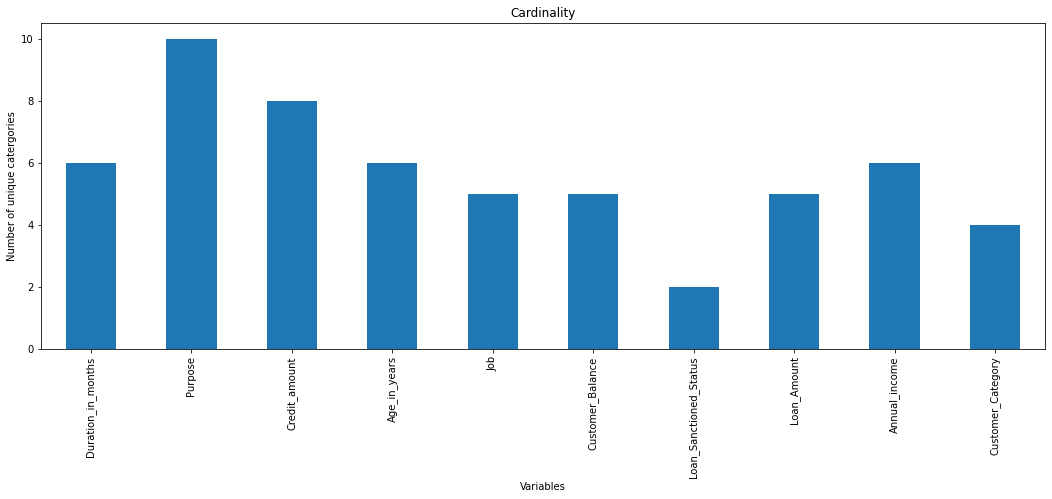

In [21]:
# write code here
x_train_bin[categorical_vars].nunique(dropna=False).plot.bar()
plt.ylabel('Number of unique catergories')
plt.xlabel('Variables')
plt.title('Cardinality');

### Does a rare level exist in a category?
- There may be some levels within a categorical variable with low frequency of occurence

- Tipically a level may be considered "rare" when it appears in less than 5% of the population, but this is not a fixed or magical number, the percentage may be different depending on the scenario.

In [22]:
# level frequency
for i in list(x_train_bin[categorical_vars].columns):
    label_freq = x_train_bin[categorical_vars].loc[:,i].value_counts()/ len(x_train_bin)
    print(label_freq)

[15.50, 34.50)    0.397015
[11.50, 15.50)    0.258209
[34.50, 43.50)    0.097015
(-inf, 7.50)      0.089552
[7.50, 11.50)     0.085075
[43.50, inf)      0.073134
Name: Duration_in_months, dtype: float64
A43     0.273134
A40     0.231343
A42     0.189552
A41     0.104478
A49     0.101493
A46     0.044776
A45     0.022388
A410    0.011940
A48     0.010448
A44     0.010448
Name: Purpose, dtype: float64
[1373.00, 2675.00)    0.307463
[959.50, 1373.00)     0.131343
[4049.50, 6686.00)    0.131343
[2675.00, 3504.00)    0.128358
(-inf, 959.50)        0.116418
[3504.00, 4049.50)    0.064179
[6686.00, 8918.00)    0.062687
[8918.00, inf)        0.058209
Name: Credit_amount, dtype: float64
[25.50, 34.50)    0.365672
[38.50, 52.50)    0.223881
(-inf, 25.50)     0.191045
[52.50, inf)      0.085075
[34.50, 36.50)    0.080597
[36.50, 38.50)    0.053731
Name: Age_in_years, dtype: float64
A173       0.622388
A172       0.194030
A174       0.158209
A171       0.020896
missing    0.004478
Name: Job, dtype

### `Practice:`
1) Use the above loop (exclude the print) to generate a bar plot visual for each level of every categorical variable.
2) Add a horizontal red line at y = 0.025.
3) visual details:
    - title = Rare categories
    - y label: Level occurence percentage within the population
    - x label = Variable name

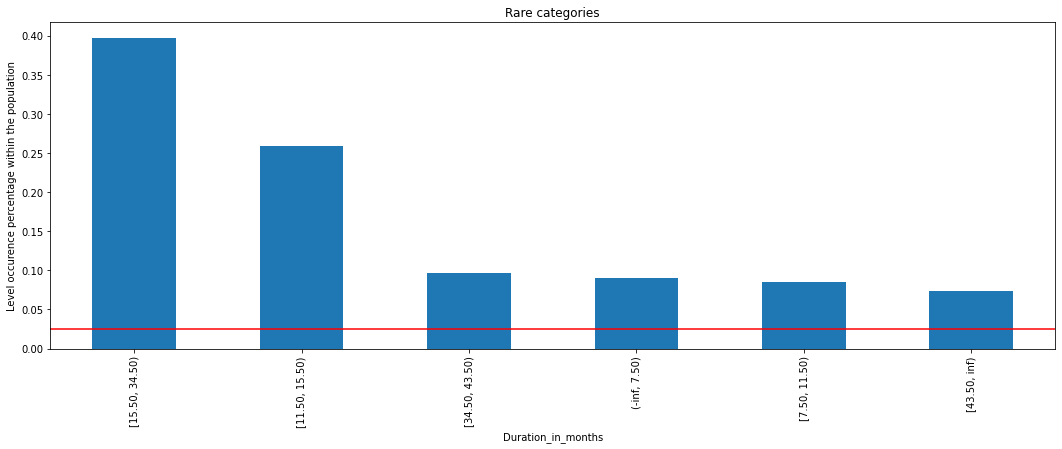

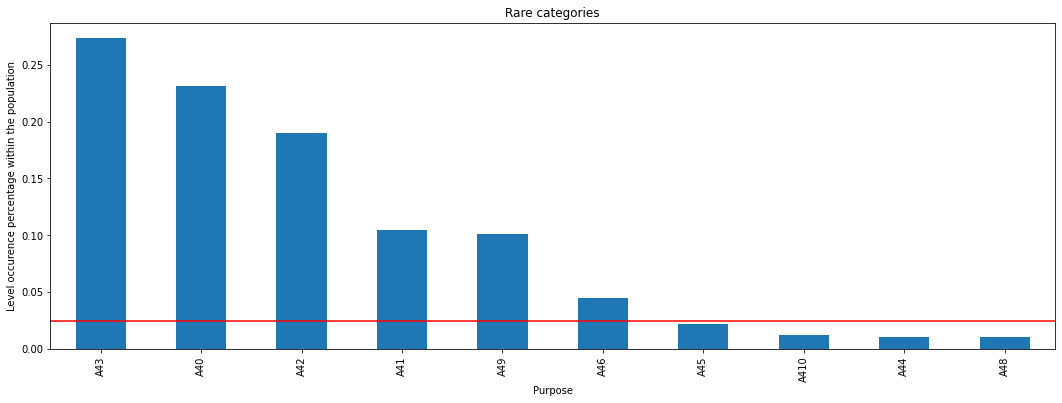

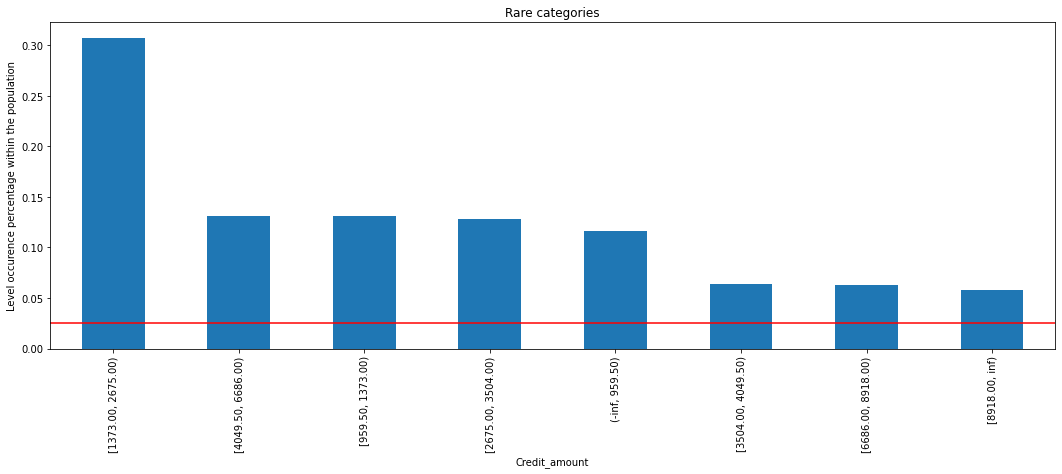

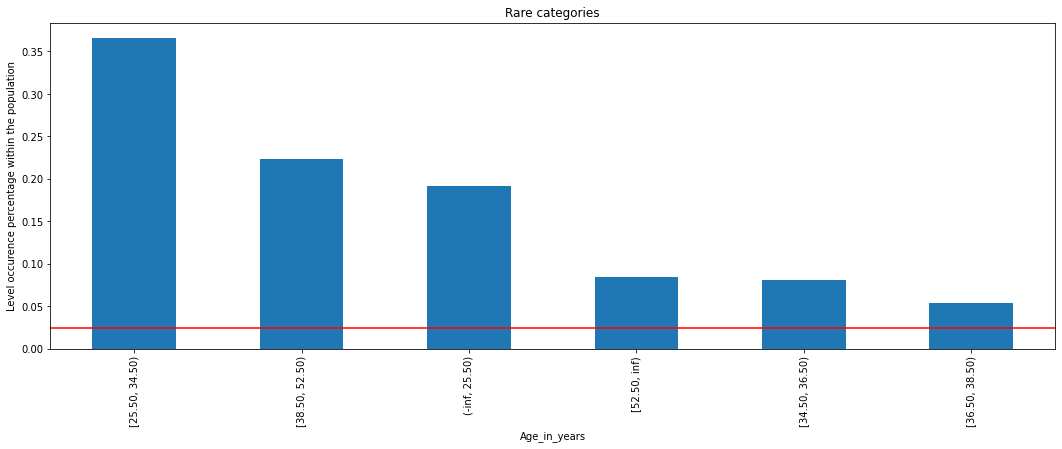

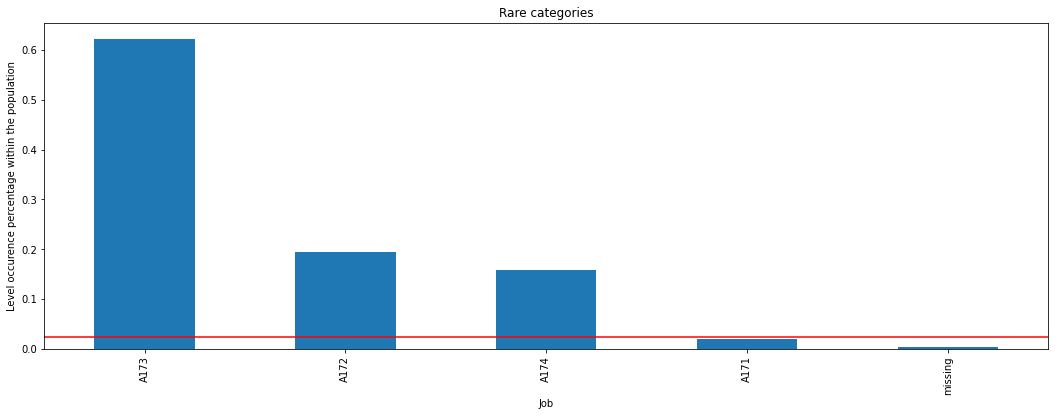

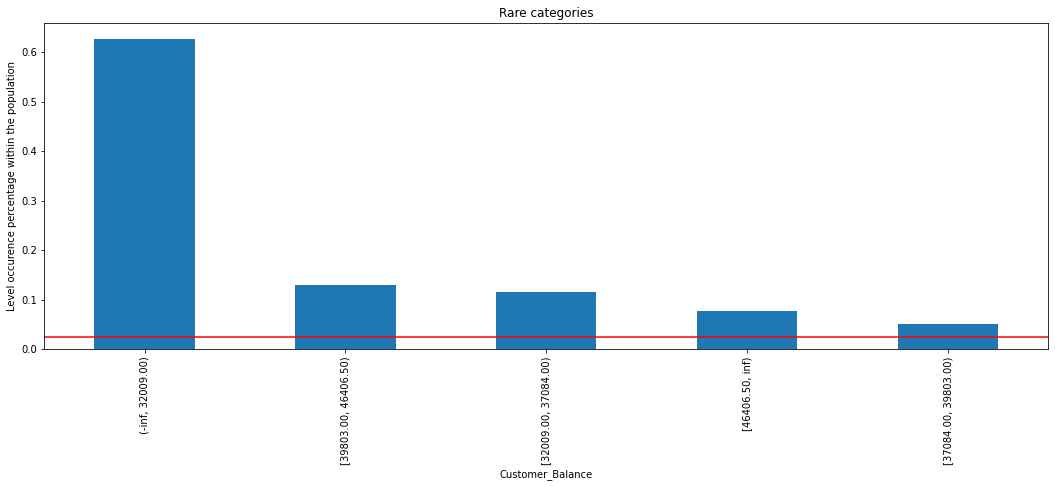

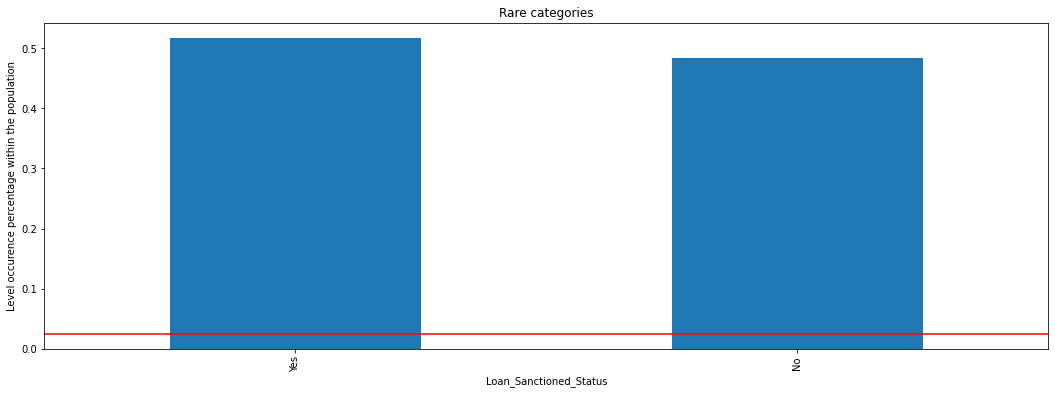

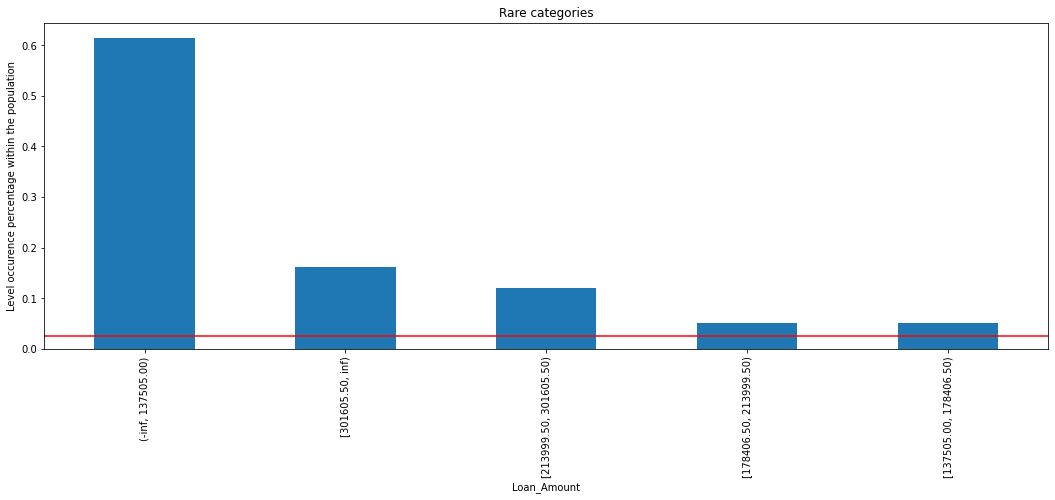

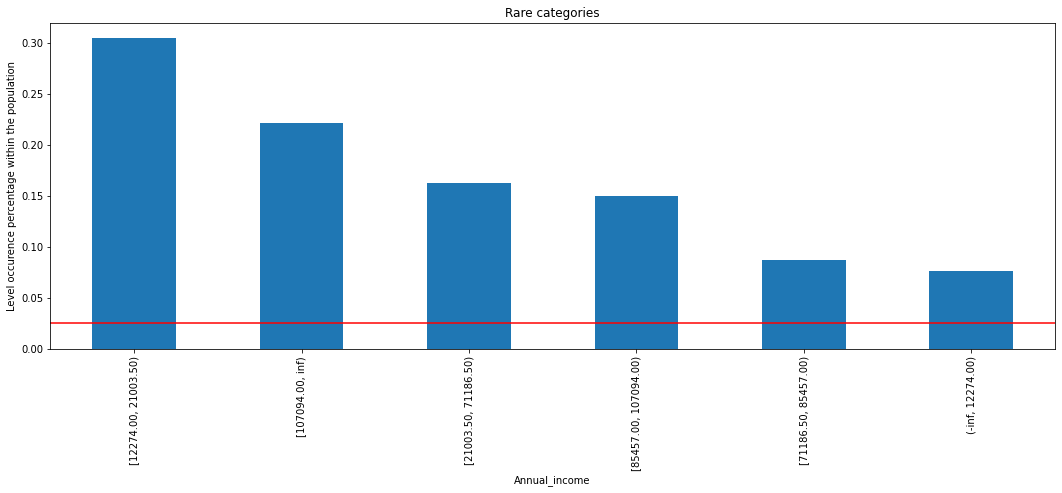

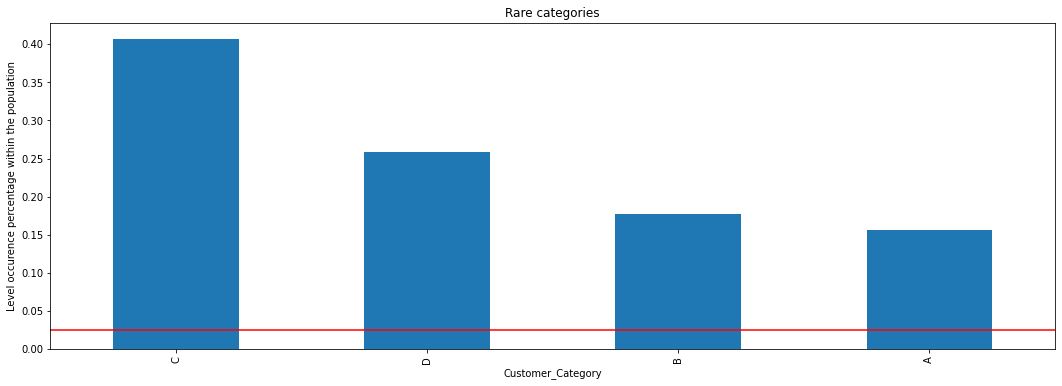

In [23]:
# write code here
for i in list(x_train_bin[categorical_vars].columns):
    label_freq = x_train_bin[categorical_vars].loc[:,i].value_counts()/ len(x_train_bin)
    fig = label_freq.sort_values(ascending = False).plot.bar()
    fig.axhline(y = 0.025, color = 'red')
    fig.set_ylabel('Level occurence percentage within the population')
    fig.set_xlabel(i)
    fig.set_title('Rare categories')
    plt.show();

### After having identified rare levels, now we can consider the encoding for the categorical variables.

- Categorical values need to be encoded (re-represented) before building a learning model. Most algorithms cannot deal with categorical values as is.

- Factors such as type of model to use (linear or tree based), learning type (supervised or unsupervised), and type of categorical variable (nominal or ordinal), determines encoding methods that would be best to use. 


### There are many ways to do encoding, but for now we'll be using:

- **Binary map encoding**: assign a 0 or 1 for a two level categorical variables.

| Original | Encoded |
| --- | --- |
| A | 0 |
| B | 1 |


- **One-hot encoding**: create a new column for each unique label/level (1 for its corresponding label, 0 in all other columns). This is done only for frequet (None rare) levels. The rare levels will be combined into a single column named "rare category".

| Original | Encoded A | Encoded B | Encoded C | Encoded Rare |
| --- | --- | --- | --- |--- |
| A | 1 | 0 | 0 | 0 |
| B | 0 | 1 | 0 | 0 |
| C | 0 | 0 | 1 | 0|
| ... | ... | ... | ... | ..|
| Rare | 0 | 0 | 0 | 1|

### For the encoding process:
- 1) identify columns with only 2 levels, use `.map` to encode to 0/1
- 2) combine the rare levels into 1 level called rare for each categorical variables with more than 2 levels
- 3) one hot encode categorical variables with more than 2 levels after grouping rare levels. 

In [24]:
# lets create a function to replace all rare labels
def find_frequent_labels(X:pd.DataFrame,col:str,rare_threshold:float=0.025):
    temp =  X[col].value_counts() / len(X)
    frequent = [x for x in temp.loc[temp > rare_threshold].index.values]
    return frequent

# vars with 2 levels
def two_level_encoding(X_train:pd.DataFrame,X_test:pd.DataFrame, categoricals:list):
    # train
    df_temp_train = pd.get_dummies(X_train[categoricals], drop_first =True).astype(float)
    X_train[df_temp_train.columns.to_list()] = df_temp_train.copy()
    X_train = X_train.drop(columns = categoricals)
    # test
    df_temp_test = pd.get_dummies(X_test[categoricals], drop_first =True).astype(float)
    X_test[df_temp_test.columns.to_list()] = df_temp_test.copy()
    X_test = X_test.drop(columns = categoricals)
    return X_train, X_test

# vars with more than 2 levels
def multi_level_encoding(X_train:pd.DataFrame,X_test:pd.DataFrame,categoricals:list,rare_threshold:float=0.025):
    for i in categoricals:
        freq_categories = find_frequent_labels(X = X_train, col = i, rare_threshold = rare_threshold)
        X_train[i] = np.where(X_train[i].isin(freq_categories),X_train[i],'Rare')
    # rare encoder fit
    rare_encoder = RareLabelEncoder(tol = rare_threshold, n_categories = 2)
    rare_encoder.fit(X_train)
    X_encoded_train, X_encoded_test = rare_encoder.transform(X_train) , rare_encoder.transform(X_test)
    X_encoded_train = pd.get_dummies(X_encoded_train, drop_first =False).astype(float)
    X_encoded_test = pd.get_dummies(X_encoded_test, drop_first =False).astype(float)
    return X_encoded_train, X_encoded_test

In [25]:
# list of categoricals of 2 levels
two_labels = list(cardinality[cardinality == 2].index)
x_train_bin, x_test_bin = two_level_encoding(X_train = x_train_bin,X_test=x_test_bin, categoricals = two_labels)

# list of categoricals of more than 2 levels
multi_labels = list(cardinality[cardinality >2].index)
x_train_bin, x_test_bin = multi_level_encoding(X_train = x_train_bin,X_test=x_test_bin, categoricals = multi_labels)

x_train_bin

,Loan_Sanctioned_Status_Yes,"Duration_in_months_(-inf, 7.50)","Duration_in_months_[11.50, 15.50)","Duration_in_months_[15.50, 34.50)","Duration_in_months_[34.50, 43.50)","Duration_in_months_[43.50, inf)","Duration_in_months_[7.50, 11.50)",Purpose_A40,Purpose_A41,Purpose_A42,Purpose_A43,Purpose_A46,Purpose_A49,Purpose_Rare,"Credit_amount_(-inf, 959.50)","Credit_amount_[1373.00, 2675.00)","Credit_amount_[2675.00, 3504.00)","Credit_amount_[3504.00, 4049.50)","Credit_amount_[4049.50, 6686.00)","Credit_amount_[6686.00, 8918.00)","Credit_amount_[8918.00, inf)","Credit_amount_[959.50, 1373.00)","Age_in_years_(-inf, 25.50)","Age_in_years_[25.50, 34.50)","Age_in_years_[34.50, 36.50)","Age_in_years_[36.50, 38.50)","Age_in_years_[38.50, 52.50)","Age_in_years_[52.50, inf)",Job_A172,Job_A173,Job_A174,Job_Rare,"Customer_Balance_(-inf, 32009.00)","Customer_Balance_[32009.00, 37084.00)","Customer_Balance_[37084.00, 39803.00)","Customer_Balance_[39803.00, 46406.50)","Customer_Balance_[46406.50, inf)","Loan_Amount_(-inf, 137505.00)","Loan_Amount_[137505.00, 178406.50)","Loan_Amount_[178406.50, 213999.50)","Loan_Amount_[213999.50, 301605.50)","Loan_Amount_[301605.50, inf)","Annual_income_(-inf, 12274.00)","Annual_income_[107094.00, inf)","Annual_income_[12274.00, 21003.50)","Annual_income_[21003.50, 71186.50)","Annual_income_[71186.50, 85457.00)","Annual_income_[85457.00, 107094.00)",Customer_Category_A,Customer_Category_B,Customer_Category_C,Customer_Category_D
973,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
935,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
449,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
495,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
177,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
578,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
728,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
391,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [26]:
# list of categoricals of 2 levels
two_labels = ['Loan_Sanctioned_Status']
x_train_log_minmax, x_test_log_minmax = two_level_encoding(X_train = x_train_log_minmax, X_test=x_test_log_minmax, categoricals = two_labels)

# list of categoricals of more than 2 levels
multi_labels = ['Purpose', 'Job', 'Customer_Category']
x_train_log_minmax, x_test_log_minmax = multi_level_encoding(X_train = x_train_log_minmax,X_test=x_test_log_minmax, categoricals = multi_labels)

x_train_log_minmax

,Duration_in_months,Credit_amount,Age_in_years,Customer_Balance,Loan_Amount,Annual_income,Loan_Sanctioned_Status_Yes,Purpose_A40,Purpose_A41,Purpose_A42,Purpose_A43,Purpose_A46,Purpose_A49,Purpose_Rare,Job_A172,Job_A173,Job_A174,Job_Rare,Customer_Category_A,Customer_Category_B,Customer_Category_C,Customer_Category_D
973,1.000000,0.768210,0.460813,0.637158,0.000000,0.320395,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
935,0.729401,0.434012,0.328281,0.739971,0.000000,0.234207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
449,0.464993,0.374387,0.847492,0.682447,0.000000,0.236881,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
495,0.643406,0.545460,0.036547,0.782844,0.000000,0.072715,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
177,0.134512,0.000000,0.730007,0.489560,0.980294,0.833286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,0.729401,0.631232,0.278325,0.650558,0.880429,0.763762,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
578,0.800132,0.530313,0.252039,0.834295,0.000000,0.193449,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
728,0.912429,0.736011,0.822930,0.594046,0.000000,0.056887,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
391,0.381985,0.266709,0.000000,0.296548,0.975451,0.793984,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### DSP - Feature Selection: 

- Is the process of selecting a subset of relevant features for use in model construction. 
- Feature selection helps to identify the most relevant features, reduce the dimensionality of the data, and improve the interpretability of the model. 
- There are several techniques for feature selection, including:
    - Filter methods (examples: Correlation filtering) - These are methods that do not require a model. 
    - Wrapper methods (examples: Forward/Backward/Stepwise Selection)
    - Embedded methods (examples: Feature Importance)

### Correlations: Pearson

In general, this coefficient (Pearson) can be interpreted as follows:
- Magnitudes:
    - .00-.19 `very weak`
    - .20-.39 `weak`
    - .40-.59 `moderate`
    - .60-.79 `strong`
    - .80-1.0 `very strong`
- Sign:
    - positive indicate a proportional relationship
    - negative indicate a inverse proportional relationship

Pearson's correlation have some mathematical assumptions in order to be used properly. These can be summerized as:
 - variables must be continous
 - data must be linear
 - outliers affects the score

It is defined as:

 $$ Correlation = \frac{\sum{(X - X_{MEAN})*(Y - Y_{MEAN})}}{\sqrt{\sum{(X - X_{MEAN})^2}*\sum{(Y - Y_{MEAN})^2}}} $$

In [27]:
cor_matrix_tri = x_train.corr(method='pearson').where(np.triu(np.ones(x_train.corr(method='pearson').shape)).astype(bool)).fillna(0)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Duration_in_months,Credit_amount,Age_in_years,Customer_Balance,Loan_Amount,Annual_income
Duration_in_months,1.000000,0.616677,-0.043387,-0.082618,-0.066255,-0.030515
Credit_amount,0.000000,1.000000,0.024147,-0.017414,-0.003425,-0.040710
Age_in_years,0.000000,0.000000,1.000000,0.062770,-0.036821,-0.036691
Customer_Balance,0.000000,0.000000,0.000000,1.000000,-0.011385,-0.014368
Loan_Amount,0.000000,0.000000,0.000000,0.000000,1.000000,0.785081
Annual_income,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


### Correlations: Spearman

- Spearman does not assumes linear relationship nor restricst ordinal variables. 
- It follows the same interpretation as the Pearson score

It is defined as:

 $$ Correlation = 1 - (\frac{(6*\sum{(X_{RANK} - Y_{RANK})^2})}{(N*(N^2-1))}) $$

where:
- N is the number of data points

In [28]:
cor_matrix_tri = x_train.corr(method='spearman').where(np.triu(np.ones(x_train.corr(method='spearman').shape)).astype(bool)).fillna(0)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Duration_in_months,Credit_amount,Age_in_years,Customer_Balance,Loan_Amount,Annual_income
Duration_in_months,1.000000,0.630293,-0.032450,-0.088001,-0.058173,-0.031539
Credit_amount,0.000000,1.000000,0.049482,-0.012018,-0.005022,-0.022264
Age_in_years,0.000000,0.000000,1.000000,0.073750,-0.018339,-0.009871
Customer_Balance,0.000000,0.000000,0.000000,1.000000,-0.012842,-0.029942
Loan_Amount,0.000000,0.000000,0.000000,0.000000,1.000000,0.803183
Annual_income,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


### Correlation: Cramér’s V.

- Is a measure of association between two categorical features based on a nominal variation of Pearson’s Chi-Square Test.

- The output is in the range of [0,1], where 0 means no association and 1 is full association.

- The output matrix is also symmetrical, therofre asumes the same association for (x,y) and (y,x)

- Cramer’s V may lead to a loss of information due to the symmetry of it.

It is defined as:
 $$ Correlation = \sqrt{\frac{\chi^2}{(N*MIN(k,l))}} $$

where:
- $\chi^2$ is the chi-squared statistic
- N is the sample size
- k is the number of categories in the first variable
- l is the number of categories in the second variable.

In [29]:
def cramers_v(X:pd.Series, Y:pd.Series,rounding=2):
    x, y = X.copy(), Y.copy()
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))),rounding)

def categorical_correlation_matrix(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in categorical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(cramers_v(X = df[i], Y = df[j]))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

In [30]:
cor_matrix_tri = categorical_correlation_matrix(x_train).where(np.triu(np.ones(categorical_correlation_matrix(x_train).shape)).astype(bool)).fillna(0)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Customer_Category,Job,Loan_Sanctioned_Status,Purpose
Customer_Category,1.000000,0.000000,0.770000,0.000000
Job,0.000000,1.000000,0.000000,0.140000
Loan_Sanctioned_Status,0.000000,0.000000,1.000000,0.090000
Purpose,0.000000,0.000000,0.000000,1.000000


### Correlation: Theil’s U
- Theil’s U is a measure of the degree of inequality in a distribution.

- The output value is on the range of [0,1], with the same interpretations as before — but unlike Cramer’s V, it is asymmetric.

- It answers the following question:  given the value of x, how many possible states does y have, and how often do they occur?

- Using Theil’s U will let us find out that knowing y means we know x, but not vice-versa.

It is defined as:
$$ Correlation = \frac{(-\sum{P_{Xi}*LOG(P_{Xi})}) - (-\sum{P_{Yi}*LOG(P_{Yi})})}{LOG(N)} $$


where:
- $P_{Xi}$ and $P_{Yi}$ are the probability of each value in the distributions X and Y
- N is the number of values in the distribution.

In [31]:
def conditional_entropy(X:pd.Series,Y:pd.Series,log_base:float = math.e):
    x , y = X.copy(), Y.copy()
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

def theils_u(X:pd.Series,Y:pd.Series,rounding=2):
    x , y = X.copy(), Y.copy()
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return round((s_x - s_xy) / s_x,rounding)

def categorical_correlation_matrix(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in categorical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(theils_u(X = df[i], Y = df[j]))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

In [32]:
cor_matrix_tri = categorical_correlation_matrix(x_train)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Customer_Category,Job,Loan_Sanctioned_Status,Purpose
Customer_Category,1.000000,0.010000,0.310000,0.020000
Job,0.010000,1.000000,0.000000,0.070000
Loan_Sanctioned_Status,0.600000,0.000000,1.000000,0.020000
Purpose,0.010000,0.040000,0.010000,1.000000


### Correlation: Correlation Ratio

- The Correlation Ratio answers the following question: Given a continuous number, how well can you know to which category it belongs to? 

- Just like the two coefficients we’ve seen before, here too the output is on the range of [0,1].

It is defined as:
$$ Correlation = \frac{\sum_{X}{N_{X}*(\bar{Y}_{X} - \bar{Y})^2}}{\sum_{X,i}{(Y_{Xi} - \bar{Y})^2}} $$

where:
- $Y_{Xi}$ is each observation where X indicates the category that observation is in and i is the label of observation.

- $N_{X}$ is the number of observations in category X

- $\bar{Y}_{X}$ is the mean of the category X

- $\bar{Y}$ is the mean of the whole population

In [33]:
def correlation_ratio(categorical_var:pd.Series, numerical_var:pd.Series,rounding=2):
    categories , measurements = categorical_var.copy(), numerical_var.copy().astype(int)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return round(eta,rounding)

def mixed_correlation_matrix(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    numerical_vars = list(df.select_dtypes(exclude = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in numerical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(correlation_ratio(categorical_var = df[i].values, numerical_var = df[j].values))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

In [34]:
cor_matrix_tri = mixed_correlation_matrix(x_train)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Age_in_years,Annual_income,Credit_amount,Customer_Balance,Duration_in_months,Loan_Amount
Customer_Category,0.050000,0.710000,0.090000,0.050000,0.090000,0.660000
Job,0.150000,0.060000,0.350000,0.130000,0.230000,0.060000
Loan_Sanctioned_Status,0.030000,0.920000,0.030000,0.020000,0.040000,0.840000
Purpose,0.150000,0.140000,0.350000,0.080000,0.250000,0.140000


### **Wrapper Methods**: Uses a metric to determined best features, therefore a model is used in the selection.

### Stepwise Feature Selection
- This method is a global, recursive method that iterates over all combination of variables.

- If there are many variables, filtering high correlated variables might speed the process

In [35]:
# Remove correlated columns
def create_corr(X_:np.ndarray,y:np.ndarray):
    X = np.copy(X_)
    n = X.shape[1]
    correl = np.ones((n, n), dtype=float)
    for i in range(n - 1):
        for j in range(i + 1, n):
            arr = np.hstack([X[:,i].reshape(-1,1), X[:,j].reshape(-1,1)])
            arr = arr[(arr != -1).all(axis=1)]
            try:
                corre = pearsonr(arr[:,0], arr[:,1])[0]
            except:
                corre = 0
            correl[i, j] = correl[j, i] = corre
    correl = np.nan_to_num(correl)
    corr_matrix = 1 - np.fabs(correl)
    return corr_matrix
    
# Runs clustering to remove correlated features
def main_process_cluster(X:pd.DataFrame, y:pd.Series):
    X,y = X.copy() , y.copy()
    estimator = LGBMClassifier()
    search_space = optuna_param_disp[estimator.__class__.__name__]
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=123)
    os = OptunaSearchCV(estimator=estimator,scoring="roc_auc",cv=rskf,search_space=search_space,n_iter=2,random_state=33)
    stepw = DynamicStepwise(estimator=os,rounding=4,n_combs=2,direction="forward",max_cols=2)
    clsl = ClusterSelection(t=0.65, meta_estimator=stepw, make_matrix=create_corr)
    clsl.fit(X, y)
    cluster_columns = list(clsl.get_feature_names_out())
    return X[cluster_columns]


# feature selection via stepwise
def main_process_stepwise(X:pd.DataFrame, y:pd.Series, direction:str):
    X,y = X.copy() , y.copy()
    estimator = LGBMClassifier()
    search_space = optuna_param_disp[estimator.__class__.__name__]
    rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=33)
    os = OptunaSearchCV(estimator=estimator,scoring="roc_auc",cv=rskf,search_space=search_space,n_iter=2,random_state=33)
    add_always = False    
    if direction == 'backward':
        add_always = True
    stepw = DynamicStepwise(estimator=os,rounding=4,add_always=add_always,n_combs=2,direction=direction,n_jobs=-1)
    stepw.fit(X, y)
    out = pd.DataFrame(stepw.seq_columns_selected_, columns=["Score", "Columns Added"])
    columns_to_use = list(out.loc[out['Score'].idxmax(),'Columns Added'])
    return X[columns_to_use]

### Remove correlated variables

In [36]:
remove_correlated = main_process_cluster(X = x_train_log_minmax, y = y_train) 
remove_correlated

23-01-04 18:11 | INFO | Cluster 1 - Evaluating columns: ['Customer_Category_B' 'Customer_Category_C']
23-01-04 18:11 | INFO | Number of cores to be used: 4, total available: 4

23-01-04 18:11 | INFO | Remaining columns to test: 2
23-01-04 18:11 | INFO | Combinations to test: 3
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
23-01-04 18:12 | INFO | Best score from combinations: 0.5165, global score 0
23-01-04 18:12 | INFO | Best score comes from adding columns: ['x1']
23-01-04 

,Duration_in_months,Credit_amount,Age_in_years,Customer_Balance,Loan_Amount,Purpose_A40,Purpose_A41,Purpose_A42,Purpose_A43,Purpose_A46,Purpose_A49,Purpose_Rare,Job_A172,Job_A174,Job_Rare,Customer_Category_A,Customer_Category_C,Customer_Category_D
973,1.000000,0.768210,0.460813,0.637158,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
935,0.729401,0.434012,0.328281,0.739971,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
449,0.464993,0.374387,0.847492,0.682447,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
495,0.643406,0.545460,0.036547,0.782844,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
177,0.134512,0.000000,0.730007,0.489560,0.980294,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658,0.729401,0.631232,0.278325,0.650558,0.880429,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
578,0.800132,0.530313,0.252039,0.834295,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
728,0.912429,0.736011,0.822930,0.594046,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
391,0.381985,0.266709,0.000000,0.296548,0.975451,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Foward selection process

In [37]:
remove_correlated_foward = main_process_stepwise(X = remove_correlated, y = y_train, direction = 'forward')
remove_correlated_foward

23-01-04 18:12 | INFO | Number of cores to be used: 4, total available: 4

23-01-04 18:12 | INFO | Remaining columns to test: 18
23-01-04 18:12 | INFO | Combinations to test: 171
23-01-04 18:12 | INFO | Best score from combinations: 0.5993, global score 0
23-01-04 18:12 | INFO | Best score comes from adding columns: ['Duration_in_months' 'Purpose_A43']
23-01-04 18:12 | INFO | Best columns were added. All columns added so far ['Duration_in_months' 'Purpose_A43']

23-01-04 18:12 | INFO | Remaining columns to test: 16
23-01-04 18:12 | INFO | Combinations to test: 136
23-01-04 18:12 | INFO | Best score from combinations: 0.6302, global score 0.5993
23-01-04 18:12 | INFO | Best score comes from adding columns: ['Purpose_A41' 'Purpose_A49']
23-01-04 18:12 | INFO | Best columns were added. All columns added so far ['Duration_in_months' 'Purpose_A41' 'Purpose_A43' 'Purpose_A49']

23-01-04 18:12 | INFO | Remaining columns to test: 14
23-01-04 18:12 | INFO | Combinations to test: 105
23-01-04 18

,Purpose_A40,Purpose_A46
973,0.0,0.0
935,0.0,0.0
449,0.0,0.0
495,0.0,0.0
177,0.0,0.0
...,...,...
658,0.0,0.0
578,1.0,0.0
728,0.0,0.0
391,0.0,0.0


In [38]:
search_function = optuna_param_disp[RandomForestClassifier.__name__]
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
os = OptunaSearchCV(estimator=RandomForestClassifier(),
                   scoring="roc_auc",cv=cv,search_space=search_function,n_iter=3)
os.fit(remove_correlated_foward,y_train)

23-01-04 18:12 | INFO | Trials: 1, Best Score: 0.5476542676865104, Score 0.5476542676865104
23-01-04 18:12 | INFO | Trials: 2, Best Score: 0.5497601448520962, Score 0.5497601448520962
23-01-04 18:12 | INFO | Trials: 3, Best Score: 0.5497601448520962, Score 0.547388283637388


OptunaSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=None),
               estimator=RandomForestClassifier(), n_iter=3, scoring='roc_auc',
               search_space=<function _random_forest_classifier_default at 0x7fa144ef8f70>,
               verbose=0)

### Backward selection process

In [39]:
remove_correlated_backward = main_process_stepwise(X = remove_correlated, y = y_train, direction = 'backward')
remove_correlated_backward

23-01-04 18:12 | INFO | Number of cores to be used: 4, total available: 4

23-01-04 18:12 | INFO | With all columns, score is 0.5261

23-01-04 18:12 | INFO | Remaining columns to test: 18
23-01-04 18:12 | INFO | Combinations to test: 171
23-01-04 18:13 | INFO | Best score from combinations: 0.6344, global score 0.5261
23-01-04 18:13 | INFO | Best score comes from removing columns: ['Purpose_Rare' 'Customer_Category_D']
23-01-04 18:13 | INFO | Best columns were removed. All columns removed so far ['Purpose_Rare' 'Customer_Category_D']

23-01-04 18:13 | INFO | Remaining columns to test: 16
23-01-04 18:13 | INFO | Combinations to test: 136
23-01-04 18:13 | INFO | Best score from combinations: 0.6268, global score 0.6344
23-01-04 18:13 | INFO | Best score comes from removing columns: ['Credit_amount' 'Purpose_A49']
23-01-04 18:13 | INFO | Best columns were removed. All columns removed so far ['Credit_amount' 'Purpose_A49' 'Purpose_Rare' 'Customer_Category_D']

23-01-04 18:13 | INFO | Remai

,Purpose_Rare,Customer_Category_D
973,0.0,1.0
935,0.0,1.0
449,1.0,1.0
495,0.0,1.0
177,0.0,0.0
...,...,...
658,0.0,0.0
578,0.0,0.0
728,0.0,1.0
391,0.0,0.0


In [40]:
search_function = optuna_param_disp[RandomForestClassifier.__name__]
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2)
os = OptunaSearchCV(estimator=RandomForestClassifier(),
                   scoring="roc_auc",cv=cv,search_space=search_function,n_iter=3)
os.fit(remove_correlated_backward,y_train)

23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.4859620947213495, Score 0.4859620947213495
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.48896778592264617, Score 0.48896778592264617
23-01-04 18:14 | INFO | Trials: 3, Best Score: 0.520402027847693, Score 0.520402027847693


OptunaSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=None),
               estimator=RandomForestClassifier(), n_iter=3, scoring='roc_auc',
               search_space=<function _random_forest_classifier_default at 0x7fa144ef8f70>,
               verbose=0)

###  **Embedded Methods**: Also requires a model, but in the construction of such, it fixes the variables so the selection can be done observing each iteration of the model.

### Feature importance
- It only works with certain types of models, such as decision trees and random forests, which provide feature importance scores.
- It also does not consider the relationship between features or the performance of the model

In [41]:
def rf_importances(X:pd.DataFrame, Y:pd.Series, method:str = 'Default'):
    x,y = X.copy() , Y.copy()
    rf = RandomForestClassifier()
    rf.fit(x,y)
    if method == 'Default':
        importances = pd.DataFrame(data={'Attribute': x.columns,'Importance': rf.feature_importances_}).sort_values(by='Importance', ascending=False)
        importances.plot(x='Attribute',y='Importance',kind='bar',xlabel='Variables',ylabel='Importance')
        return importances
    elif method == 'Permutation':
        per_imp_rf = permutation_importance(rf, x, y ,n_repeats=25,n_jobs=-1,random_state=33)
        importances = pd.DataFrame(data={'Attribute': x_train_log_minmax.columns,'Importance': per_imp_rf.importances_mean}).sort_values(by='Importance', ascending=False)
        importances.plot(x='Attribute',y='Importance',kind='bar',xlabel='Variables',ylabel='Importance')
        return importances
    else:
        print('method must be Default or Permutation')

,Attribute,Importance
1,Credit_amount,0.164148
3,Customer_Balance,0.140868
5,Annual_income,0.139335
2,Age_in_years,0.130147
0,Duration_in_months,0.113294
4,Loan_Amount,0.084135
7,Purpose_A40,0.024053
15,Job_A173,0.019836
10,Purpose_A43,0.018012
20,Customer_Category_C,0.017778


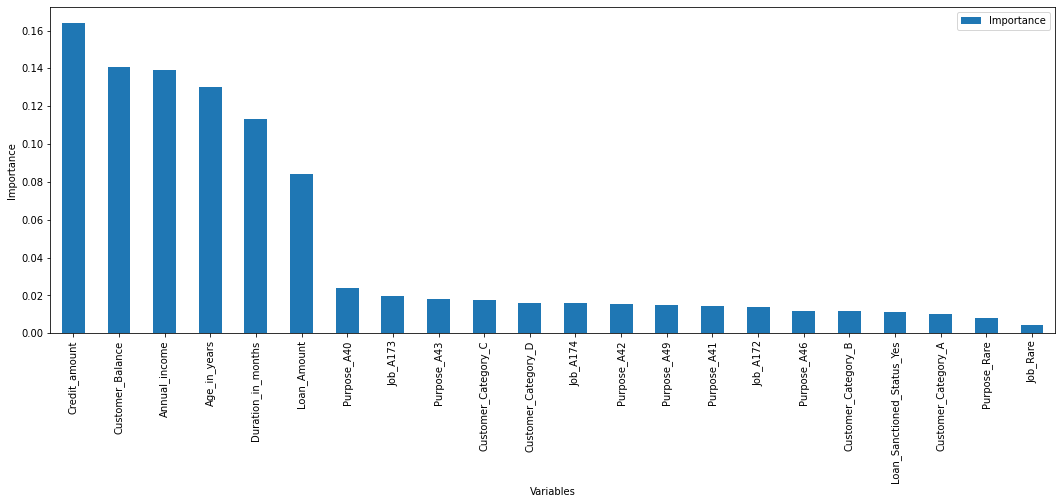

In [42]:
rf_importances(X = x_train_log_minmax, Y = y_train, method='Default')

### Key note when talking about Feature Importance

- Using feature importance of models such as random forest may lead to select un-useful variables for prediction due to sensitivity to noise.

- Permutation Importance is preferable over random forest alone, but it may be more complex to interpret


,Attribute,Importance
1,Credit_amount,0.080119
2,Age_in_years,0.068597
0,Duration_in_months,0.054687
3,Customer_Balance,0.048418
4,Loan_Amount,0.044836
5,Annual_income,0.038866
7,Purpose_A40,0.029552
20,Customer_Category_C,0.017254
10,Purpose_A43,0.011582
8,Purpose_A41,0.011164


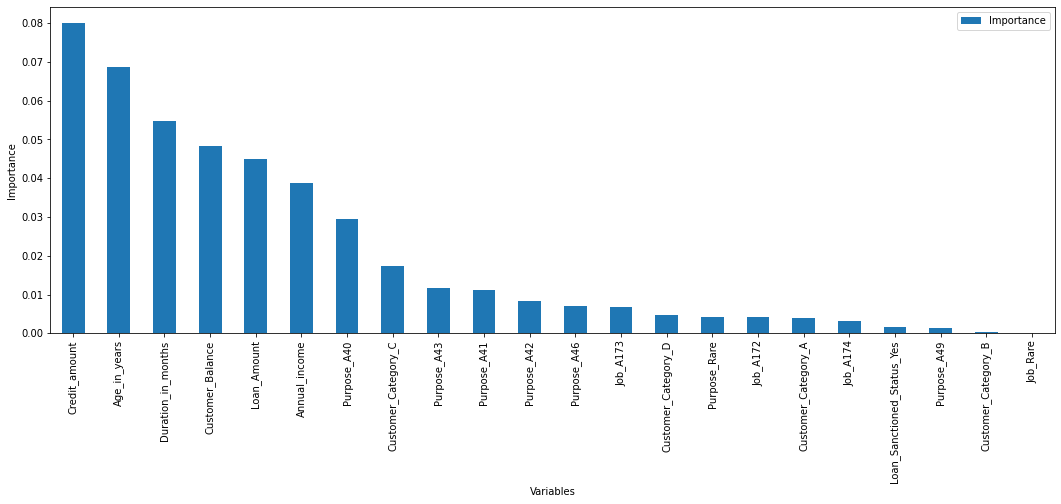

In [43]:
rf_importances(X = x_train_log_minmax, Y = y_train, method='Permutation')

### Simulated Annealing - Local Search

- This is a local, stochastic method that yields good (not always optimal), fast solution

- There are some parameters in this method, but those are not discussed today.

In [44]:
def train_model(X, y,estimator=RandomForestClassifier()):
    search_function = optuna_param_disp[estimator.__class__.__name__]
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=2)
    os = OptunaSearchCV(estimator=estimator,scoring="roc_auc",cv=cv,search_space=search_function,n_iter=2)
    bm = os.fit(X,y)                             
    return bm.best_score_ 

def simulated_annealing(X_train,y_train,maxiters=50,cooling_rate=0.85,T_0=1,update_iters=1):
    columns = ['Iteration', 'Feature Count', 'Feature Set', 'Metric', 'Best Metric',
               'Acceptance Probability', 'Random Number', 'Outcome']
    results = pd.DataFrame(index=range(maxiters), columns=columns)
    best_subset = None
    hash_values = set()
    T = T_0
    full_set = set(np.arange(len(X_train.columns)))
    curr_subset = set(random.sample(list(full_set), round(0.5 * len(full_set))))
    X_curr = X_train.iloc[:, list(curr_subset)]
    prev_metric = train_model(X_curr, y_train)
    best_metric = prev_metric
    for i in range(maxiters):
        if T < 0.01:
            print(f'Temperature {T} below threshold. Termination condition met')
            break
        while True:
            if len(curr_subset) == len(full_set): 
                move = 'Remove'
            elif len(curr_subset) == 2:
                move = random.choice(['Add', 'Replace'])
            else:
                move = random.choice(['Add', 'Replace', 'Remove'])
            pending_cols = full_set.difference(curr_subset) 
            new_subset = curr_subset.copy()   
            if move == 'Add':        
                new_subset.add(random.choice(list(pending_cols)))
            elif move == 'Replace': 
                new_subset.remove(random.choice(list(curr_subset)))
                new_subset.add(random.choice(list(pending_cols)))
            else:
                new_subset.remove(random.choice(list(curr_subset)))
            if new_subset in hash_values:
                print('Subset already visited')
            else:
                hash_values.add(frozenset(new_subset))
                break
        X_new = X_train.iloc[:, list(new_subset)]
        metric = train_model(X_new, y_train)
        if metric > prev_metric:
            print('Local improvement in metric from {:8.4f} to {:8.4f} '
                  .format(prev_metric, metric) + ' - New subset accepted')
            outcome = 'Improved'
            accept_prob, rnd = '-', '-'
            prev_metric = metric
            curr_subset = new_subset.copy()
            if metric > best_metric:
                print('Global improvement in metric from {:8.4f} to {:8.4f} '
                      .format(best_metric, metric) + ' - Best subset updated')
                best_metric = metric
                best_subset = new_subset.copy()
        else:
            rnd = np.random.uniform()
            diff = prev_metric - metric
            accept_prob = np.exp(-1*diff / T)

            if rnd < accept_prob:
                print('New subset has worse performance but still accept. Metric change' +
                      ':{:8.4f}, Acceptance probability:{:6.4f}, Random number:{:6.4f}'
                      .format(diff, accept_prob, rnd))
                outcome = 'Accept'
                prev_metric = metric
                curr_subset = new_subset.copy()
            else:
                print('New subset has worse performance, therefore reject. Metric change' +
                      ':{:8.4f}, Acceptance probability:{:6.4f}, Random number:{:6.4f}'
                      .format(diff, accept_prob, rnd))
                outcome = 'Reject'

        results.loc[i, 'Iteration'] = i+1
        results.loc[i, 'Feature Count'] = len(curr_subset)
        results.loc[i, 'Feature Set'] = sorted(curr_subset)
        results.loc[i, 'Metric'] = metric
        results.loc[i, 'Best Metric'] = best_metric
        results.loc[i, 'Acceptance Probability'] = accept_prob
        results.loc[i, 'Random Number'] = rnd
        results.loc[i, 'Outcome'] = outcome

        if i % update_iters == 0:
            T = cooling_rate * T
                
    best_subset_cols = [list(X_train.columns)[i] for i in list(best_subset)]
    results = results.dropna(axis=0, how='all')

    return results, best_metric, best_subset_cols

In [45]:
results, best_metric, best_subset_cols = simulated_annealing(x_train_log_minmax,y_train,maxiters=10,cooling_rate=0.95,T_0=5,update_iters=1)

23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.5520607466528306, Score 0.5520607466528306
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5520607466528306, Score 0.5241977386021615
23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.5629306857807719, Score 0.5629306857807719
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5667037531442174, Score 0.5667037531442174


Local improvement in metric from   0.5521 to   0.5667  - New subset accepted
Global improvement in metric from   0.5521 to   0.5667  - Best subset updated


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.4968930055383761, Score 0.4968930055383761
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5388164629025302, Score 0.5388164629025302


New subset has worse performance but still accept. Metric change:  0.0279, Acceptance probability:0.9941, Random number:0.3857


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.5123975076132502, Score 0.5123975076132502
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5222244580985206, Score 0.5222244580985206


New subset has worse performance but still accept. Metric change:  0.0166, Acceptance probability:0.9963, Random number:0.4291


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.478475143156571, Score 0.478475143156571
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5424737296719551, Score 0.5424737296719551


Local improvement in metric from   0.5222 to   0.5425  - New subset accepted


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.47335413024664386, Score 0.47335413024664386
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.48389573433444893, Score 0.48389573433444893


New subset has worse performance but still accept. Metric change:  0.0586, Acceptance probability:0.9857, Random number:0.0419


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.5997179636568186, Score 0.5997179636568186
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5997179636568186, Score 0.5676081537926407


Local improvement in metric from   0.4839 to   0.5997  - New subset accepted
Global improvement in metric from   0.5667 to   0.5997  - Best subset updated


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.55554902699694, Score 0.55554902699694
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.55554902699694, Score 0.5218071699513682


New subset has worse performance but still accept. Metric change:  0.0442, Acceptance probability:0.9881, Random number:0.8898


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.5172736261410475, Score 0.5172736261410475
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5172736261410475, Score 0.5163921108049118


New subset has worse performance but still accept. Metric change:  0.0383, Acceptance probability:0.9891, Random number:0.6159


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.587930343741307, Score 0.587930343741307
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.587930343741307, Score 0.5661849138715906


Local improvement in metric from   0.5173 to   0.5879  - New subset accepted


23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.5760809967990851, Score 0.5760809967990851
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5760809967990851, Score 0.5624398069289049


New subset has worse performance but still accept. Metric change:  0.0118, Acceptance probability:0.9962, Random number:0.3493


In [46]:
os.fit(x_train_log_minmax.loc[:,best_subset_cols],y_train)

23-01-04 18:14 | INFO | Trials: 1, Best Score: 0.5565702959302196, Score 0.5565702959302196
23-01-04 18:14 | INFO | Trials: 2, Best Score: 0.5595640454071312, Score 0.5595640454071312
23-01-04 18:14 | INFO | Trials: 3, Best Score: 0.5595640454071312, Score 0.5370144464245253


OptunaSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=3, random_state=None),
               estimator=RandomForestClassifier(), n_iter=3, scoring='roc_auc',
               search_space=<function _random_forest_classifier_default at 0x7fa144ef8f70>,
               verbose=0)